# AirBnb in NY (check http://insideairbnb.com/get-the-data.html )

### What do we know? Do we know things? Let's find out!

<br>

## Problem definition and "business view"

We want to analyse the listing activity of AirBnb in NYC.
<br>
AirBnb is an online marketplace for arranging homestays and tourism services. As it does not own any of the locations, its primary purpose is to connect hosts to potential visitors. 

In this analysis we try to evaluate how the rental properties are distributed throughout the different neighbourhoods in New York and correlate the geographical location with the rental prices, and the property type (private room/apartment/hotel room).
By correlating the different features of the listings and using machine learning techniques, we try to predict the pricing according to the property features and neighbourhood. Using this approach we can determine the best value and experience for the customer.

One factor which influences the AirBnB experience is, whether the property is owned by an individual or a cooperation. We try to analyze this through the number of listings owned by an individual, the days the property can be rented out and using text mining to evalaute the listing description. What are the most commonly used attributes in the description of the listings and how do they correlate with neighbourhood and price range? 

Through the analysis we try ro determine whether the evaluated features correlate with being a superhost, meaning, what does it take for your property to be sucessful. 
Furthermore, we try to predict which factors imply a good 'deal' on your AirBnB. How's the price develeopment over time and can we predict the prices for the listings according to their geographical location? 


## Problem Feature

**Important!** There are two primary keys in highlight (so far):

* The ID of the listed flat;
* The ID of the host.

It may be also useful to divide the dataset in 4 macro-areas, just to clear ideas:

* Info about the flat, such as its location, number of rooms, minimum nights, etc.;
* Details about the host, e.g., his/her name, popularity, etc.;
* The social part, i.e., details about the description of the listings or the reviews they receive;
* The time-frame, which means anything related to the seasonality of the use/offer of the service.

#### Possible targets:

* Create a new variable called 'price range' and classify it in terms of the location details. It may be a good way to use some geofilters;
* Figure out the impact that some attributes, like the descriptions, have on the popularity of the host. One can try to answer the question: what does it take to be a superhost?
* Try to estimate what is the best time of the year to use AirBnb and fly to meet Pizza Rat.

# Framework selection

Import modules, define functions, string connection. 

In [1]:
#Import "Standard-Modules"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import warnings
import re

#Nécessaire for Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import OrderedDict

#Geometrical modules
#import geopandas as gpd
#import descartes as cart
#from shapely.geometry import Point, Polygon

#Modules for cross-validation etc.
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn import tree

from imblearn.under_sampling import RandomUnderSampler

#Some modules to manage time series
from time import gmtime, strftime

In [2]:
#Setting the display options

#Pandas - Show more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Set default style for seaborn and pyplot
sns.set_style("darkgrid")
plt.matplotlib.style.use('default')
%matplotlib inline
plt.rcParams.update({'font.size': 10})

#Create customised palette
my_colors = ["windows blue", "saffron", "hot pink", "algae green", "dusty purple", 
             "greyish", "petrol", "denim blue", "lime", "dark cyan", "indigo", "khaki",
             "navy", "red violet" , "shamrock", "stone", "stormy blue", "wintergreen", "wisteria",
             "heather", "liliac"]

sns.set_palette(sns.xkcd_palette(my_colors))
colors = sns.xkcd_palette(my_colors)

In [3]:
#Modules and functions to interact with our Database
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from psycopg2.errors import DuplicateDatabase
from sqlalchemy import create_engine, exc

In [4]:
#Historise preprocessed data
def to_historised_table(df, table_name, engine_str):
    try:
        sqlalc_engine = create_engine(engine_str) 
        df_ = df.copy()
        df_['Timestamp'] = strftime("%Y-%m-%d %H:%M:%S", gmtime())
        df_.to_sql(name=table_name, con=sqlalc_engine, if_exists = 'append', index=False, chunksize=100)
        print('The data has been saved')
        version = pd.read_sql('SELECT COUNT(DISTINCT Timestamp) AS Version from {}'.format(table_name),sqlalc_engine)
        print('The table has been saved in its Version {}.'.format(str(version.iloc[0,0])))
        return
    except exc.ProgrammingError as pre:
        print(pre)
        return
    except:
        print('An unknown error occurred.')
        raise          

In [5]:
#Hide warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
#Custom functions

#Summary of database
def my_df_summary(data):
    '''A customised overviwew of the database'''
    try:
        dat = data.copy()
        df = pd.DataFrame([dat.min(), dat.max(), dat.mean(), dat.std(), dat.isna().sum(), dat.nunique(), dat.dtypes],
                     index=['Minimum', 'Maximum', 'Mean', 'Std. Dev.','#NA', '#Uniques', 'dtypes'])        
        return df
    except:
        print('No summary could be displayed')
        return data
    
def missing_data(data):
    '''A function to visualise missing data'''
    dat = data.copy()
    
    df = pd.DataFrame(dat.isna().sum(), columns=['Missing'])
    df['pct'] = [round(m/len(dat),2) for m in df['Missing']]
    
    #output contains only incomplete columns --> readability
    if len(df.loc[df['pct'] != 0]):
        return df.loc[df['pct'] != 0]
    else:
        print('Dataframe complete')
        return
    
def cardinality_count(data):
    '''A function to highlight columns with high cardinality'''
    dat = data.copy()
    
    if len(dat.select_dtypes('object'))==0:
        print('No categorical columns.')
        return
    else:
        df = pd.Series(dat.select_dtypes('object').nunique())
        df = pd.DataFrame(df, columns = ['uniques'])
        df['pct'] = df['uniques']/len(dat)
        return df    
    
#Exception handling - databases
from sqlalchemy import exc

def exec_sql(str_sql,str_con):
    try:
        f_engine = create_engine(str_con)
        df_return = pd.read_sql(str_sql, f_engine)
        print("The action has been successfully executed.")
        return df_return
    except exc.ProgrammingError as pre:
        print('Watch out! An error has arisen!')
        print()
        print('The statement '+ str_sql +' is incorrect.')
        print()
        print(pre)
        return pd.DataFrame()
    except exc.ResourceClosedError as rce:
        print('The action has been executed. No data was returned.')
        return pd.DataFrame()
    except exc.IntegrityError as ie:
        print('The SQL statement is NOT faulty, but can not be executed.')
        print()
        print(ie)
        return pd.DataFrame()
    except:
        raise

#### Connection to the database

<font color='red'> IMPORTANT!</font> Uncomment the following code snippet out if you want to storage data in your own PostgreSQL database. Just make sure to insert your actual username, etc.

This is the reason why all the uploadings to SQL tables are commented in markdowns.

```python
psql = psycopg2.connect("host='localhost' user='postgres' password='****' dbname='postgres'")
psql.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
```

```python
mycursor = psql.cursor()

def create_PSQL_database(name):
    try:
        mycursor.execute("CREATE DATABASE {}".format(name))
    except DuplicateDatabase:
        print('No need to create the database "{}". It already exists.'.format(name))
    except:
        print('An unknown error occurred.')
        raise
        
create_PSQL_database('projektarbeit')
```

```python
#Create string connection to PostgreSQL database

str_db_typ = 'postgresql+psycopg2://' 
str_db_user = 'postgres:'
str_db_password = '****'    #Insert your password instead of the asterisks
str_db_adr = '@localhost'
str_db_schema = '/projektarbeit'

str_connection = str_db_typ + str_db_user + str_db_password + str_db_adr + str_db_schema

#Create engine
engine = create_engine(str_connection)
```

# Preprocessing the data

## Explorative Data Analysis (EDA)

### Data collection and storage in the database

In [7]:
df_ = pd.read_csv('listings.csv.gz')
#df_.head(1)

The columns 'host_is_superhost' and 'host_response_rate' seem interesting. Add them to the 'listing' database

In [8]:
df_lst = pd.read_csv('listings.csv')
#df_lst.head()

In [9]:
df_lst = pd.merge(df_lst, df_[['id','host_is_superhost', 'host_response_rate']], how='inner', on='id')
df_lst.head(3)

id                                              name  host_id  \
0  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
1  3831                   Cozy Entire Floor of Brownstone     4869   
2  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
1  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
2        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    150               3                  0         NaN   
1  Entire home/apt     89               1                279  2019-08-29   
2  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0                NaN                               1               365   
1               4.62                               1               192   
2               0.10                               1                 0   

  host_is_superhost host_response_rate  
0                 f                 0%  
1                 f                92%  
2                 f                NaN

In [10]:
#Convert 'last_review' column to datetime format
df_lst['last_review'] = pd.to_datetime(df_lst['last_review'], format='%Y-%m-%d', errors='ignore')
df_lst.head(5)

id                                              name  host_id  \
0  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
1  3831                   Cozy Entire Floor of Brownstone     4869   
2  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
3  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
4  5121                                   BlissArtsSpace!     7356   

     host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0    Elisabeth           Manhattan              Harlem  40.80902  -73.94190   
1  LisaRoxanne            Brooklyn        Clinton Hill  40.68514  -73.95976   
2        Laura           Manhattan         East Harlem  40.79851  -73.94399   
3        Chris           Manhattan         Murray Hill  40.74767  -73.97500   
4        Garon            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    150               3                  0         NaT   
1  Entire home/apt     89               1                279  2019-08-29   
2  Entire home/apt     80              10                  9  2018-11-19   
3  Entire home/apt    200               3                 75  2019-07-21   
4     Private room     60              45                 49  2017-10-05   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0                NaN                               1               365   
1               4.62                               1               192   
2               0.10                               1                 0   
3               0.59                               1                13   
4               0.39                               1                 0   

  host_is_superhost host_response_rate  
0                 f                 0%  
1                 f                92%  
2                 f                NaN  
3                 f                78%  
4                 f                 0%

In [11]:
#df_lst.info()

In [12]:
#Select only the interesting columns and make a new dataframe
cols = ['id','name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'availability_365']
df_flat = df_lst[cols]
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48377 entries, 0 to 48376
Data columns (total 14 columns):
id                     48377 non-null int64
name                   48360 non-null object
host_id                48377 non-null int64
neighbourhood_group    48377 non-null object
neighbourhood          48377 non-null object
latitude               48377 non-null float64
longitude              48377 non-null float64
room_type              48377 non-null object
price                  48377 non-null int64
minimum_nights         48377 non-null int64
number_of_reviews      48377 non-null int64
last_review            38726 non-null datetime64[ns]
reviews_per_month      38726 non-null float64
availability_365       48377 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 5.5+ MB


In [13]:
host_cols = ['host_id'] + [col for col in df_lst.columns if col not in df_flat.columns]
df_host = df_lst[host_cols].drop_duplicates(keep='first')    #Some hosts own more than one listing
#df_host.head()

It is better to map True to 1 and False to 0, and to write percentages as ratios

In [14]:
#Convert superhosting to 1 or 0
df_host['host_is_superhost'] = df_host['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)

#Convert host response rate from percentage to floating point
df_host['host_response_rate'] = df_host['host_response_rate'].apply(lambda x: str(x).strip('%'))
df_host['host_response_rate'] = df_host['host_response_rate'].apply(lambda x: float(x)/100)

#Visualise
df_host.head()

host_id    host_name  calculated_host_listings_count  host_is_superhost  \
0     4632    Elisabeth                               1                  0   
1     4869  LisaRoxanne                               1                  0   
2     7192        Laura                               1                  0   
3     7322        Chris                               1                  0   
4     7356        Garon                               1                  0   

   host_response_rate  
0                0.00  
1                0.92  
2                 NaN  
3                0.78  
4                0.00

#### Let's save those guys on the database

```python
#Uncomment to use
df_flat.to_sql('listings_data', con=engine, if_exists='replace', index=False, chunksize=500)

df_host.to_sql('hosts_data', con=engine, if_exists='replace', index=False, chunksize=500)
```

Add primary keys to avoid accidental overwriting of data.

```python
sql = ''' ALTER TABLE listings_data
          ADD PRIMARY KEY(id)
      '''
sql_return = exec_sql(sql, str_connection)

sql = ''' ALTER TABLE hosts_data
          ADD PRIMARY KEY(host_id)
      '''
sql_return = exec_sql(sql, str_connection)
```

## Imputation of missing values

In [15]:
#Uncomment the line below for an overview of listing database
#my_df_summary(df_flat)

In [16]:
missing_data(df_flat)

Missing  pct
last_review           9651  0.2
reviews_per_month     9651  0.2

There are only two columns containing missing data. We can take care of that in the following way:

In [17]:
#Zero-fill missing reviews
df_flat['reviews_per_month'].fillna(0, inplace=True)

In [18]:
#Check when the last review took place
pd.to_datetime(df_flat['last_review'].dropna(axis=0), format='%Y-%m-%d').min()

Timestamp('2011-03-28 00:00:00')

In [19]:
#Use the day before the earliest last review as a fill
df_flat['last_review'] = pd.to_datetime(df_flat['last_review'], format='%Y-%m-%d') # From object to datetime format
df_flat['last_review'].fillna('2011-03-27', inplace=True)   

We deal with the host table in the same way

In [20]:
#Now take care of missing values in the host table
my_df_summary(df_host)

host_id calculated_host_listings_count host_is_superhost  \
Minimum           2438                              1                 0   
Maximum    2.94185e+08                            387                 1   
Mean       6.47727e+07                        1.31549          0.170387   
Std. Dev.  7.96785e+07                        2.99926          0.375978   
#NA                  0                              0                 0   
#Uniques         36775                             48                 2   
dtypes           int64                          int64             int64   

          host_response_rate host_name  
Minimum                    0       NaN  
Maximum                    1       NaN  
Mean                0.922388       NaN  
Std. Dev.           0.183314       NaN  
#NA                    15501        19  
#Uniques                  87     11333  
dtypes               float64    object

In [21]:
missing_data(df_host)

Missing   pct
host_response_rate    15501  0.42

The column 'host_response_rate' lacks too many values. It has to be dropped completely.

In [22]:
df_host = df_host.drop('host_response_rate', axis=1)
#df_host.head()

## Understanding the big picture: visualisation of important features

Let us start with a sneak peek at correlation among different features.

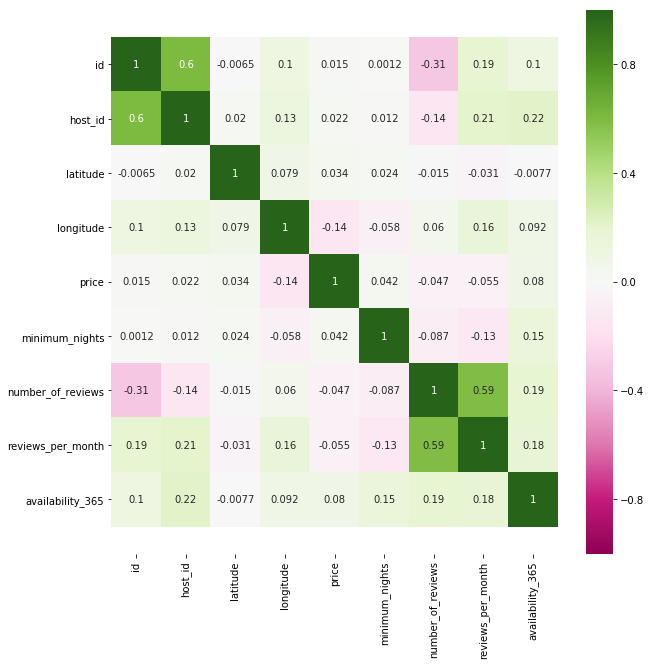

In [23]:
plt.figure(figsize=(10,10))

sns.heatmap(df_flat.corr(), vmin=-1, cmap='PiYG', annot=True);
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#The next few lines are only necessary, because otherwise graphics is distorted 
#in versions of matplotlib following 3.3. Known bug.

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [24]:
#Correlation between borough and price of listings
df_flat['price'].groupby(df_flat["neighbourhood_group"]).describe().round(2)

count    mean     std   min    25%    50%    75%  \
neighbourhood_group                                                       
Bronx                 1126.0   85.79   76.75  10.0  46.25   65.0   99.0   
Brooklyn             19856.0  122.90  181.72   0.0  60.00   90.0  149.0   
Manhattan            21183.0  199.50  329.14   0.0  95.00  150.0  223.5   
Queens                5853.0   99.02  162.88  10.0  50.00   75.0  110.0   
Staten Island          359.0  118.88  282.96  13.0  50.00   78.0  112.5   

                         max  
neighbourhood_group           
Bronx                 1000.0  
Brooklyn             10000.0  
Manhattan            10000.0  
Queens               10000.0  
Staten Island         5000.0

In [25]:
#Correlation between type of room and price
df_flat['price'].groupby(df_flat["room_type"]).describe().round(2)

count    mean     std   min    25%    50%    75%      max
room_type                                                                   
Entire home/apt  24898.0  209.81  278.11   0.0  120.0  160.0  230.0  10000.0
Hotel room         435.0  235.69  213.96  27.0  100.0  169.0  299.5   1195.0
Private room     21852.0   90.41  223.56   0.0   50.0   70.0   95.0  10000.0
Shared room       1192.0   69.62  102.04   0.0   33.0   45.0   75.0   1800.0

### Distribution neighborhood and accommodation type

Small statistical description

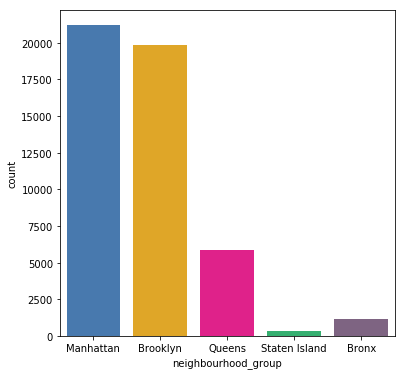

In [26]:
#Neighbourhoods
plt.figure(figsize=(6,6))
ax = sns.countplot(df_lst["neighbourhood_group"]) 

Among the five boroughs making NYC, the most of the listings is located in Brooklyn, followed by Manhattan.

In [27]:
#Visualise as pivot table
set(df_flat['neighbourhood_group'])
{'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'}
df_flat.groupby('neighbourhood_group')['price'].describe()

count        mean         std   min    25%    50%  \
neighbourhood_group                                                        
Bronx                 1126.0   85.787744   76.748294  10.0  46.25   65.0   
Brooklyn             19856.0  122.902045  181.722531   0.0  60.00   90.0   
Manhattan            21183.0  199.501534  329.135383   0.0  95.00  150.0   
Queens                5853.0   99.017769  162.877029  10.0  50.00   75.0   
Staten Island          359.0  118.883008  282.959978  13.0  50.00   78.0   

                       75%      max  
neighbourhood_group                  
Bronx                 99.0   1000.0  
Brooklyn             149.0  10000.0  
Manhattan            223.5  10000.0  
Queens               110.0  10000.0  
Staten Island        112.5   5000.0

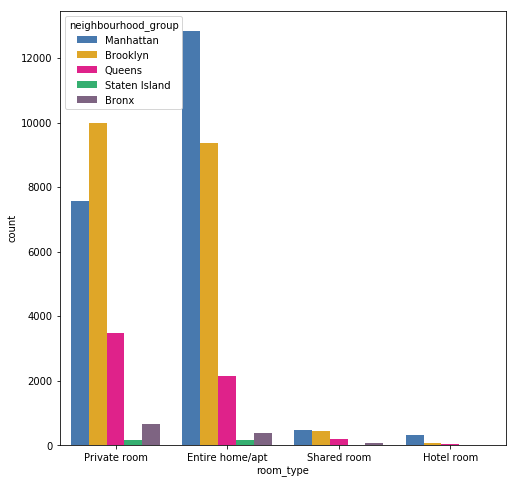

In [28]:
#Visualisation of the distribution of different room types in the 5 boroughs
plt.figure(figsize=(8,8))
ax = sns.countplot(df_flat['room_type'], hue=df_flat['neighbourhood_group'])
plt.show()

In [29]:
#Tabular version
df_flat.pivot_table(index='neighbourhood_group',columns='room_type',values='price',aggfunc='mean').round(2)

room_type            Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_group                                                        
Bronx                         126.90         NaN         62.82        74.60
Brooklyn                      176.34      116.33         76.07        49.71
Manhattan                     247.83      272.72        121.20        87.82
Queens                        146.39      128.10         71.26        70.26
Staten Island                 174.67         NaN         63.96        54.82

Average prices range from 175\\$ on Staten Island up to 248\\$ in Manhattan for an entire apartment. Shared rooms are the budget option for travelers, starting out at only 55\\$ on Staten Island.

In [30]:
#What about the minimum nights?
df_flat.groupby('neighbourhood_group')['minimum_nights'].describe()

count      mean        std  min  25%  50%  75%     max
neighbourhood_group                                                          
Bronx                 1126.0  4.542629  15.373150  1.0  1.0  2.0  3.0   365.0
Brooklyn             19856.0  6.313457  17.320757  1.0  2.0  2.0  5.0   500.0
Manhattan            21183.0  9.030213  25.963476  1.0  2.0  3.0  6.0  1250.0
Queens                5853.0  6.090723  18.651510  1.0  1.0  2.0  3.0   500.0
Staten Island          359.0  5.022284   8.838688  1.0  1.0  2.0  3.0    90.0

#### Price vs Neighbourhood

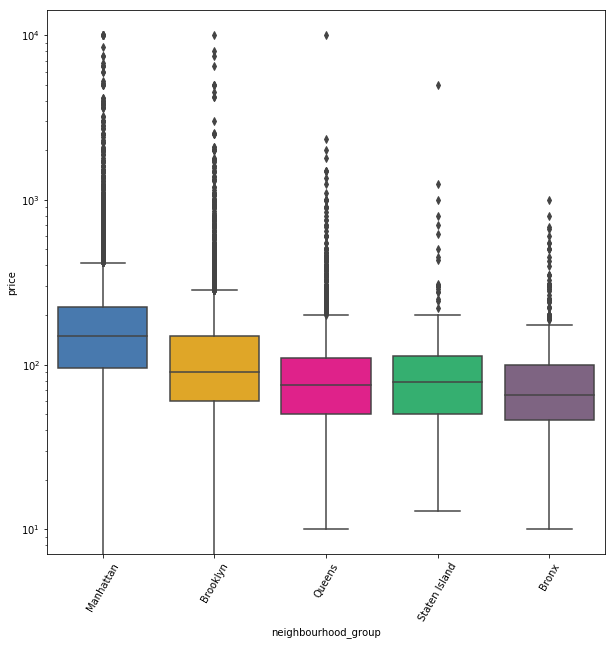

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure()

fig = sns.boxplot(x='neighbourhood_group', y='price', data=df_flat)
fig.set_yscale('log')

for item in fig.get_xticklabels():
    item.set_rotation(60)

plt.show()

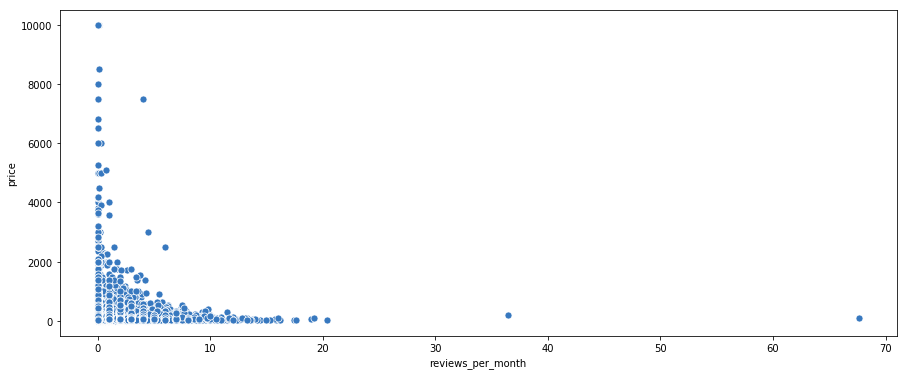

In [32]:
#Scatterplot: reviews per month vs price
plt.figure(figsize=(15,6))    
fig = sns.scatterplot(x='reviews_per_month', y='price', data=df_flat, s=50)
plt.show()

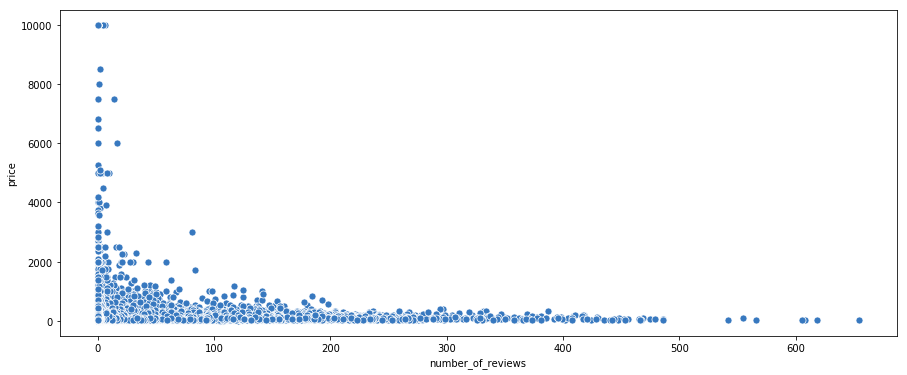

In [33]:
plt.figure(figsize=(15,6))    
fig = sns.scatterplot(x='number_of_reviews', y='price', data=df_flat, s=50)
plt.show()

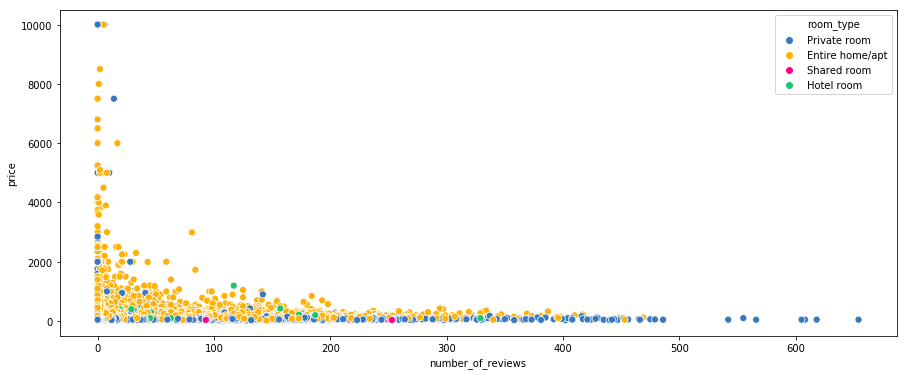

In [34]:
#price vs room types 
plt.figure(figsize=(15,6))    
fig = sns.scatterplot(x='number_of_reviews', y='price', hue='room_type', data=df_flat, s=50)
plt.show()

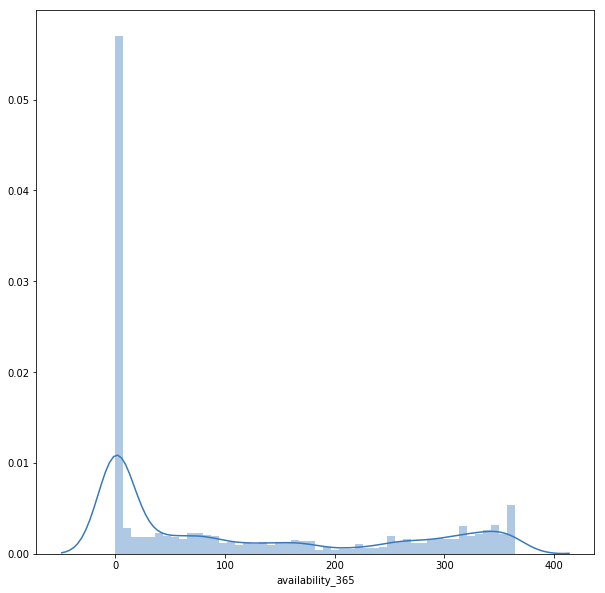

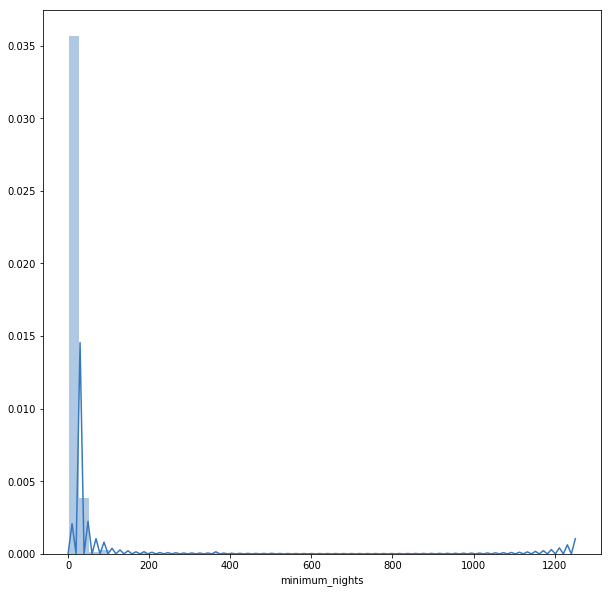

In [35]:
#Visualise the rest as distribution plot
plt.figure(figsize=[10,10])
sns.distplot(df_flat['availability_365'],bins=50)
plt.show()

plt.figure(figsize=[10,10])
sns.distplot(df_flat['minimum_nights'],bins=50)
plt.show()

### Let's look at the price. Show me the money!

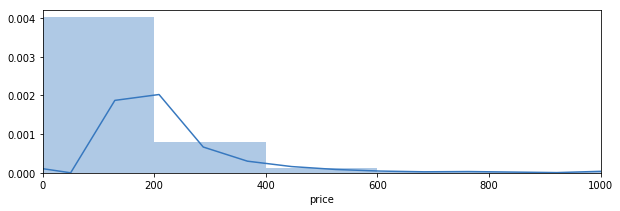

In [36]:
#Price distribution
plt.rcParams['figure.figsize'] = [10,3]

plt.figure()
ax = sns.distplot(df_flat['price'])

# Cut the x axis. The maximum price extends it to 10_000, but the remaining values are very few.
ax.set_xlim(0,1000) 

plt.show()

Wait! Does it make sense to consider the price as a continuous variable? Normally, one considers a budget range when looking at an accommodation to reserve. Nobody has a precise value to spend in mind, not a penny more not a penny less.
<br>
__Let's warm up with some feature engineering!__ We stratify the price label.
We can consider an accommodation expensive when it costs more than 200\\$, while it is cheap when the listing does not exceed 100\\$.

In [37]:
bins = [0,100,200, df_flat['price'].max()]
df_flat['price_range'] = pd.cut(df_flat['price'], bins=bins, labels=['cheap', 'normal', 'expensive'],
                               include_lowest=True)

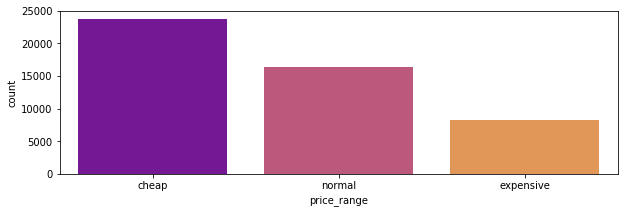

In [38]:
#Price range distribution
plt.rcParams['figure.figsize'] = [10,3]

plt.figure()
ax = sns.countplot(df_flat['price_range'], palette='plasma')

plt.show()

Some resampling has to be done later, but the 3 categories contain at least the same order of magnitude of instances.

What about the superhosts? Can we try to classify them, as we will try to do for the price? <br>
We should first ask ourselves what percentage of the population they represent.

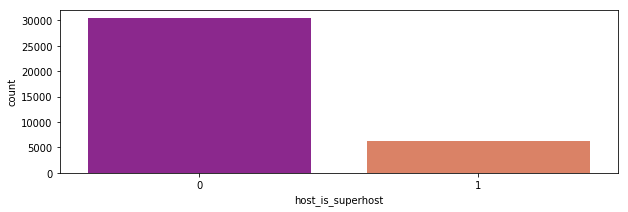

In [39]:
#Superhost distribution
plt.rcParams['figure.figsize'] = [10,3]

plt.figure()
ax = sns.countplot(df_host['host_is_superhost'], palette='plasma')

plt.show()

The superhosts are roughly 1/6 of the total. Resampling alone would be insufficient. <br>
If one wants to insist with the question, the dataset has to be improved with the addition of more superhost instances (maybe even from other cities).

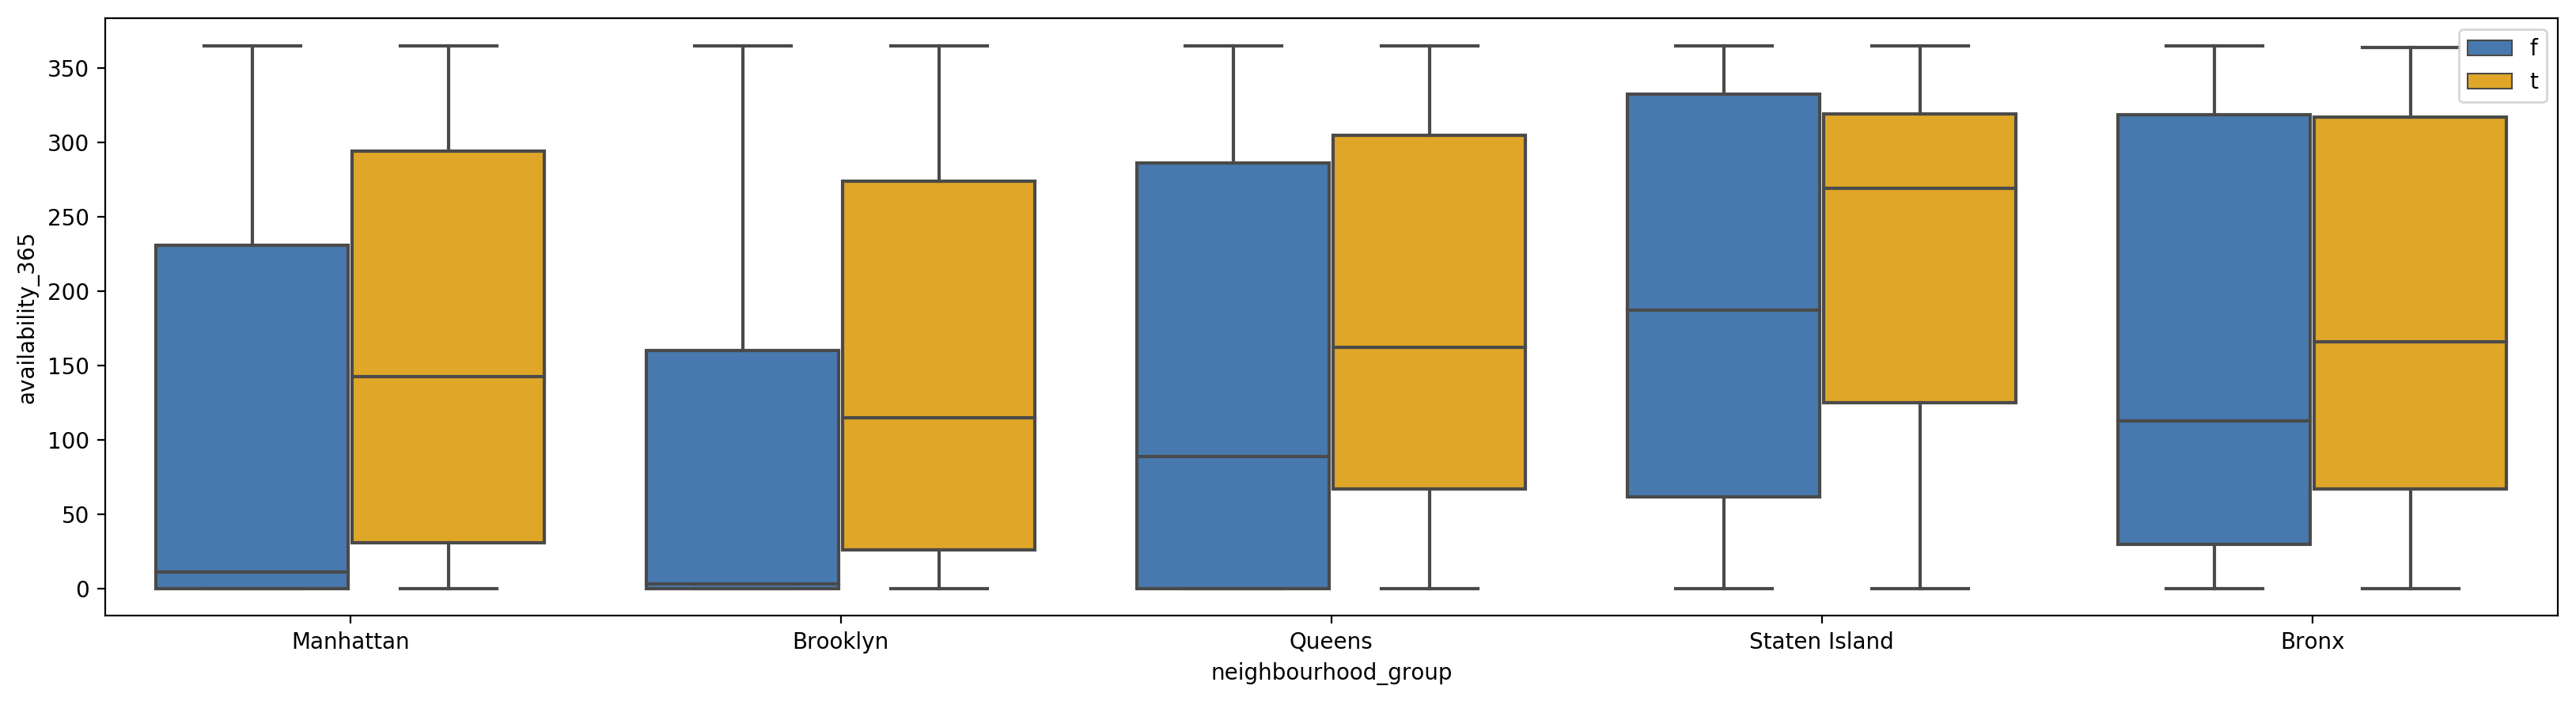

In [40]:
to_plot = df_flat[['neighbourhood_group', 'availability_365']].copy()
to_plot['host_is_superhost'] = df_lst['host_is_superhost']

#Distribution of superhosts per borough and availability
plt.figure(figsize=(20,5),dpi=200)
ax = sns.boxplot(data=to_plot, x='neighbourhood_group',y='availability_365', hue="host_is_superhost")
ax.legend(loc='best')
plt.show()

### Some histograms to count the top 30 hosts by amount of listings owned

In [41]:
countst = pd.value_counts(df_flat['host_id'].values, sort=True)

#Such hosts are indicised by their ID
countst.head()

219517861    387
107434423    240
137358866    114
30283594     113
12243051      96
dtype: int64

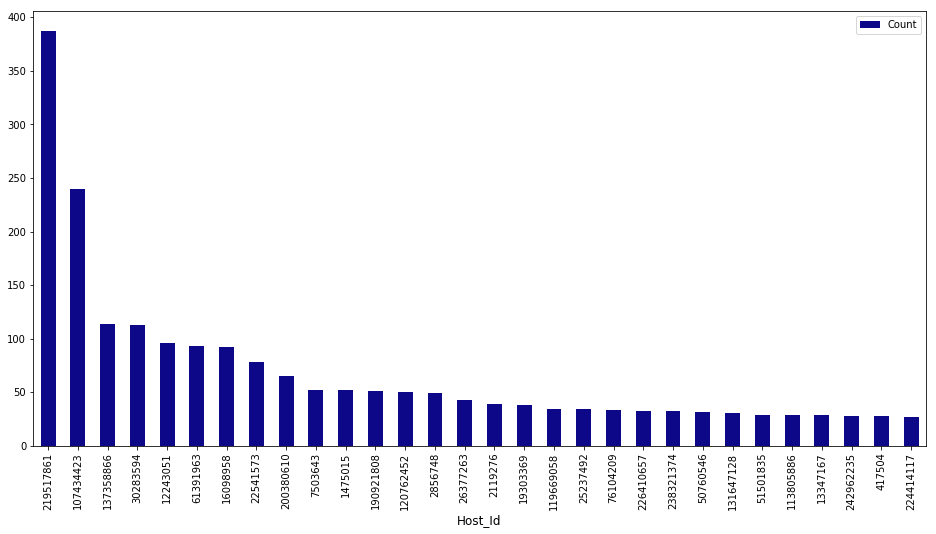

In [42]:
countst = countst[:30]

plt.figure(figsize=(16,8))

ax = countst.plot.bar(x='Host_ID', y='Count', colormap='plasma', legend=True)
ax.set_xlabel('Host_Id', fontsize=12)
ax.legend(['Count'])

plt.show()

## Geographical analysis: show the information onto a map!

Let's use scatterplot from seaborn. Geopandas and folium represent two valid alternatives.

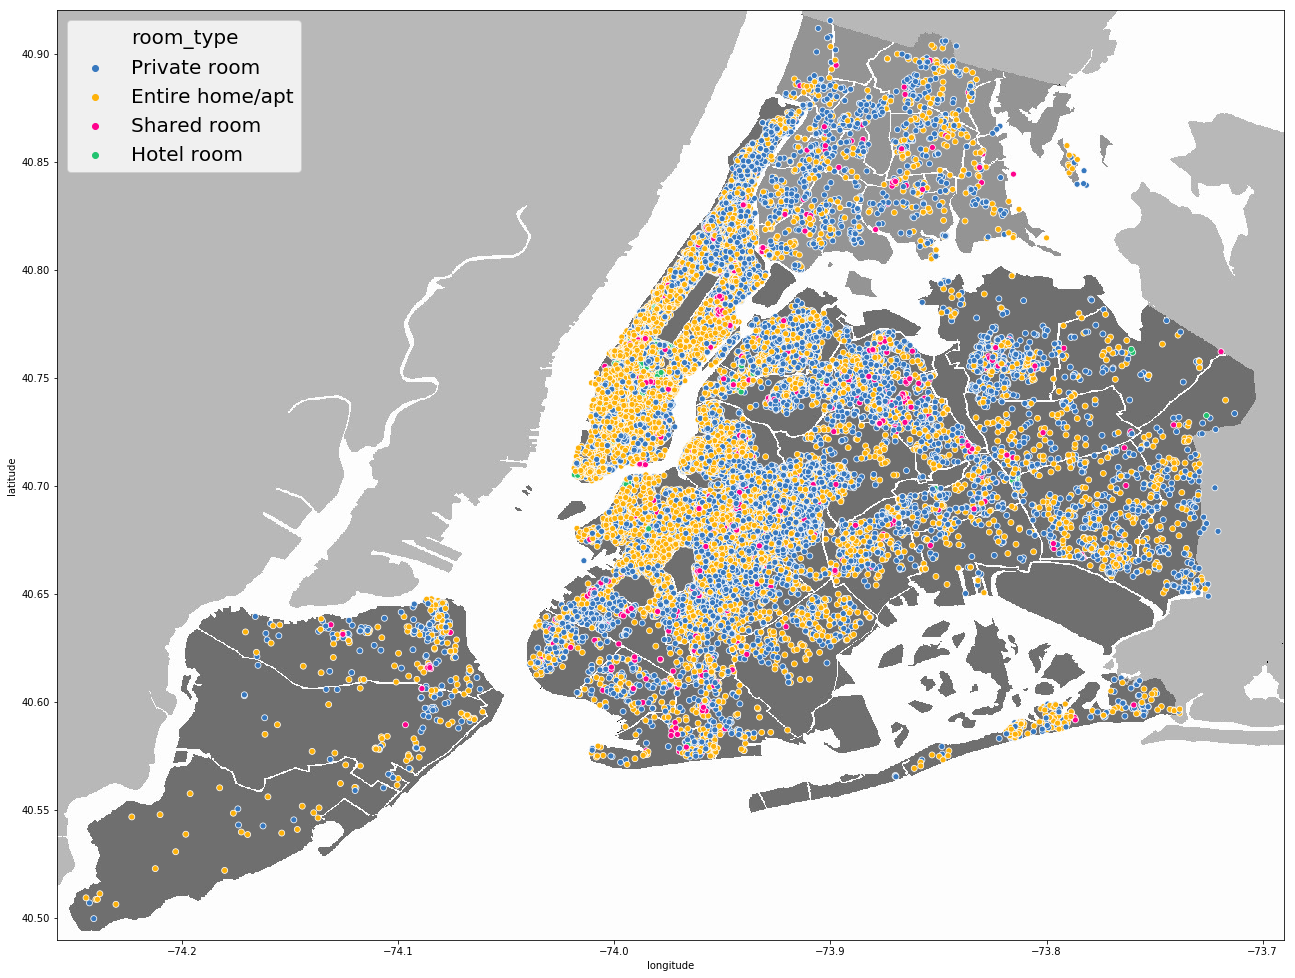

In [43]:
#distribution of room types over New York

plt.figure(figsize=[22,22])

f = sns.scatterplot(x='longitude', y='latitude', data=df_flat, hue='room_type', zorder=2)
map_img = mpimg.imread('New_York_City_.png', 0) 
plt.imshow(map_img,zorder=0,extent=[-74.258, -73.69, 40.49,40.92])
plt.legend(fontsize=20)

plt.show()

Most of the entire flats are rented in Manhattan and part of Brooklyn, while in the rest of the city is more likely to rent a single room.

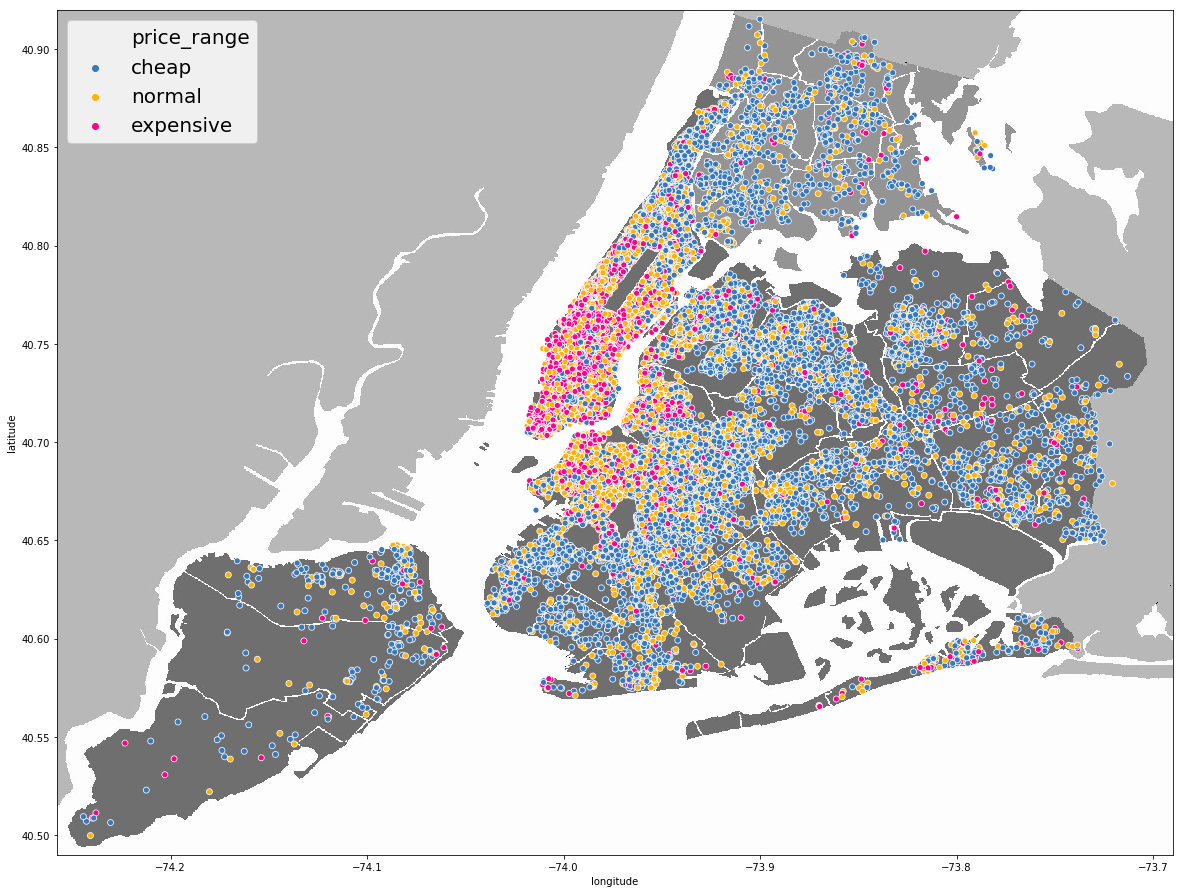

In [44]:
#distribution of prices

plt.figure(figsize=[20,20])

f = sns.scatterplot(x='longitude', y='latitude', data=df_flat, hue='price_range', zorder=2)
map_img = mpimg.imread('New_York_City_.png', 0) 

plt.imshow(map_img,zorder=0,extent=[-74.258, -73.69, 40.49,40.92])
plt.legend(fontsize=20)

plt.show()

If you are short on cash AVOID MANHATTAN!!!

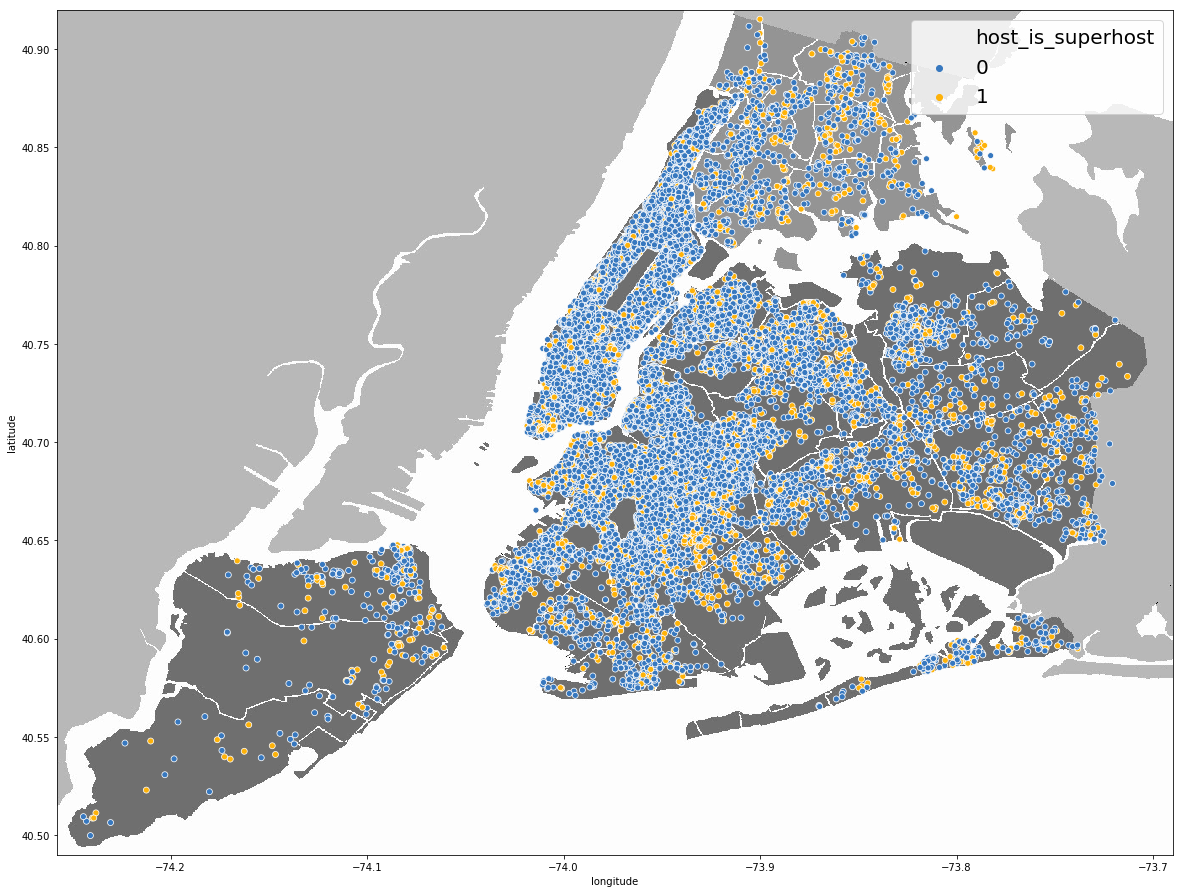

In [45]:
#distribution of superhosts

df_ = df_flat[['host_id', 'latitude', 'longitude']]
to_plot = pd.merge(df_, df_host, how='left', on='host_id')

plt.figure(figsize=[20,20])

f = sns.scatterplot(x='longitude', y='latitude', data=to_plot, hue='host_is_superhost', zorder=2)

plt.imshow(map_img,zorder=0,extent=[-74.258, -73.69, 40.49,40.92])
plt.legend(fontsize=20)

plt.show()

Note: It looks like that being a superhost does not correlate to the price of the listing. The highest density of superhosts seems to lie in Bronx and Queens

# Let's go for some classification of prices 

### Encoding of categorical variables

Split the listing database into text, time, numerical and categorical parts. The latter two are the ones we will need now.

In [46]:
df_ = df_flat.copy()

In [47]:
df_flat['last_review'] = pd.to_datetime(df_flat['last_review'], format='%Y-%m-%d')

#We create a time series, and we put it aside. We will need it later. 
df_ts = df_flat[['id','last_review']].copy()
df_.drop('last_review', axis=1, inplace=True)

#Same for the names, they will play a role during text mining
df_flat_text = df_[['id', 'name', 'neighbourhood', 'neighbourhood_group']].copy()
df_.drop('name', axis=1, inplace=True)

In [48]:
#We drop host_id and id from the numerical dataframe, as they are clearly uncorrelated with the listing price
df_flat_num = df_.select_dtypes(['int64','float64']).drop(['host_id','id'], axis=1)

df_flat_cat = df_.select_dtypes(['object','category'])

In [49]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
one_hot = OneHotEncoder()    #We need when categorical variables have no order relation among each other

Check whether some columns have high cardinality. If so, let's either feature-engineer or drop them.

In [50]:
cardinality_count(df_flat_cat)

uniques       pct
neighbourhood_group        5  0.000103
neighbourhood            224  0.004630
room_type                  4  0.000083

Columns to LabelEncode: 
* price_range

Columns to OneHotEncode:
* neighbourhood_group
* room_type

What about 'neighbourhood'? OneHotEncoding will create more than 200 new columns, but we have to do it as different neighbourhoods are not order related. We will run a PCA later.

##### Procedure for OneHotEncoding

In [51]:
neigh = df_flat_cat['neighbourhood'].copy()

In [52]:
neigh = le.fit_transform(neigh)
neigh = neigh.reshape(len(neigh),1)
neigh = one_hot.fit_transform(neigh)

Check the correlation with the price range

In [53]:
df_ = pd.DataFrame(neigh.toarray())
df_ = pd.concat([df_, df_flat_cat['price_range']], axis=1)

In [54]:
df_.corr().iloc[:(len(df_.columns)-1),-1].abs().sort_values(ascending=False)

223    1.000000
217    0.020918
13     0.020829
97     0.017124
28     0.016373
98     0.014546
205    0.014467
66     0.014005
204    0.013850
53     0.013059
130    0.012468
63     0.011051
35     0.010839
94     0.010824
209    0.009998
4      0.009949
122    0.009787
75     0.009020
212    0.008941
76     0.008025
42     0.007744
120    0.007488
162    0.007401
140    0.007299
154    0.007179
62     0.007172
82     0.006989
115    0.006935
79     0.006841
169    0.006746
193    0.006585
95     0.006336
192    0.006276
36     0.006233
161    0.006059
181    0.006041
89     0.005898
133    0.005788
56     0.005713
194    0.005494
148    0.005445
185    0.005366
70     0.005286
106    0.005121
88     0.005037
108    0.005037
65     0.004887
31     0.004821
61     0.004732
107    0.004501
111    0.004320
19     0.004258
178    0.004131
200    0.004131
7      0.004014
219    0.004000
30     0.003987
25     0.003906
54     0.003838
81     0.003810
20     0.003740
126    0.003565
118    0

In [55]:
#LabelEncoding mapped the column names to integers. Better to rename them, thanks to classes_ method
mapping = {x:y for (x,y) in enumerate(le.classes_)}

In [56]:
df_neigh = pd.DataFrame(neigh.toarray())
df_neigh = df_neigh.rename(columns=mapping)
df_ = pd.concat([df_neigh, df_flat_cat['price_range']], axis=1)

It works!

In [57]:
df_.corr().iloc[:(len(df_.columns)-1),-1].abs().sort_values(ascending=False)

Woodside                      1.000000
Williamsburg                  0.020918
Bedford-Stuyvesant            0.020829
Harlem                        0.017124
Bushwick                      0.016373
Hell's Kitchen                0.014546
Upper West Side               0.014467
East Village                  0.014005
Upper East Side               0.013850
Crown Heights                 0.013059
Midtown                       0.012468
East Harlem                   0.011051
Chelsea                       0.010839
Greenpoint                    0.010824
Washington Heights            0.009998
Astoria                       0.009949
Lower East Side               0.009787
Financial District            0.009020
West Village                  0.008941
Flatbush                      0.008025
Clinton Hill                  0.007744
Long Island City              0.007488
Prospect-Lefferts Gardens     0.007401
Murray Hill                   0.007299
Park Slope                    0.007179
East Flatbush            

##### Repeat the exact same steps for neighbourhood groups and room types

In [58]:
group = df_flat_cat['neighbourhood_group'].copy()

In [59]:
group = le.fit_transform(group)
group = group.reshape(len(group),1)
group = one_hot.fit_transform(group)

mapping = {x:y for (x,y) in enumerate(le.classes_)}

df_group = pd.DataFrame(group.toarray())
df_group = df_group.rename(columns=mapping)
df_ = pd.concat([df_group, df_flat_cat['price_range']], axis=1)

In [60]:
df_.corr().iloc[:(len(df_.columns)-1),-1].abs().sort_values(ascending=False)

Staten Island    1.000000
Manhattan        0.076314
Brooklyn         0.072145
Queens           0.032079
Bronx            0.013348
Name: Staten Island, dtype: float64

Now, the room_types

In [61]:
room = df_flat_cat['room_type'].copy()

In [62]:
room = le.fit_transform(room)
room = room.reshape(len(room),1)
room = one_hot.fit_transform(room)

mapping = {x:y for (x,y) in enumerate(le.classes_)}

df_room = pd.DataFrame(room.toarray())
df_room = df_room.rename(columns=mapping)
df_ = pd.concat([df_room, df_flat_cat['price_range']], axis=1)

In [63]:
df_.corr().iloc[:(len(df_.columns)-1),-1].abs().sort_values(ascending=False)

Shared room        1.000000
Entire home/apt    0.163674
Private room       0.144263
Hotel room         0.015140
Name: Shared room, dtype: float64

In [64]:
df_flat_cat.drop(['neighbourhood','neighbourhood_group','room_type'], axis=1, inplace=True)
df_flat_cat = pd.concat([df_flat_cat, df_neigh, df_group, df_room], axis=1)

In [65]:
df_flat_cat.head()

price_range  Allerton  Arden Heights  Arrochar  Arverne  Astoria  \
0      normal       0.0            0.0       0.0      0.0      0.0   
1       cheap       0.0            0.0       0.0      0.0      0.0   
2       cheap       0.0            0.0       0.0      0.0      0.0   
3      normal       0.0            0.0       0.0      0.0      0.0   
4       cheap       0.0            0.0       0.0      0.0      0.0   

   Bath Beach  Battery Park City  Bay Ridge  Bay Terrace  \
0         0.0                0.0        0.0          0.0   
1         0.0                0.0        0.0          0.0   
2         0.0                0.0        0.0          0.0   
3         0.0                0.0        0.0          0.0   
4         0.0                0.0        0.0          0.0   

   Bay Terrace, Staten Island  Baychester  Bayside  Bayswater  \
0                         0.0         0.0      0.0        0.0   
1                         0.0         0.0      0.0        0.0   
2                         0.0         0.0      0.0        0.0   
3                         0.0         0.0      0.0        0.0   
4                         0.0         0.0      0.0        0.0   

   Bedford-Stuyvesant  Belle Harbor  Bellerose  Belmont  Bensonhurst  \
0                 0.0           0.0        0.0      0.0          0.0   
1                 0.0           0.0        0.0      0.0          0.0   
2                 0.0           0.0        0.0      0.0          0.0   
3                 0.0           0.0        0.0      0.0          0.0   
4                 1.0           0.0        0.0      0.0          0.0   

   Bergen Beach  Boerum Hill  Borough Park  Breezy Point  Briarwood  \
0           0.0          0.0           0.0           0.0        0.0   
1           0.0          0.0           0.0           0.0        0.0   
2           0.0          0.0           0.0           0.0        0.0   
3           0.0          0.0           0.0           0.0        0.0   
4           0.0          0.0           0.0           0.0        0.0   

   Brighton Beach  Bronxdale  Brooklyn Heights  Brownsville  Bull's Head  \
0             0.0        0.0               0.0          0.0          0.0   
1             0.0        0.0               0.0          0.0          0.0   
2             0.0        0.0               0.0          0.0          0.0   
3             0.0        0.0               0.0          0.0          0.0   
4             0.0        0.0               0.0          0.0          0.0   

   Bushwick  Cambria Heights  Canarsie  Carroll Gardens  Castle Hill  \
0       0.0              0.0       0.0              0.0          0.0   
1       0.0              0.0       0.0              0.0          0.0   
2       0.0              0.0       0.0              0.0          0.0   
3       0.0              0.0       0.0              0.0          0.0   
4       0.0              0.0       0.0              0.0          0.0   

   Castleton Corners  Charleston  Chelsea  Chinatown  City Island  \
0                0.0         0.0      0.0        0.0          0.0   
1                0.0         0.0      0.0        0.0          0.0   
2                0.0         0.0      0.0        0.0          0.0   
3                0.0         0.0      0.0        0.0          0.0   
4                0.0         0.0      0.0        0.0          0.0   

   Civic Center  Claremont Village  Clason Point  Clifton  Clinton Hill  \
0           0.0                0.0           0.0      0.0           0.0   
1           0.0                0.0           0.0      0.0           1.0   
2           0.0                0.0           0.0      0.0           0.0   
3           0.0                0.0           0.0      0.0           0.0   
4           0.0                0.0           0.0      0.0           0.0   

   Co-op City  Cobble Hill  College Point  Columbia St  Concord  Concourse  \
0         0.0          0.0            0.0          0.0      0.0        0.0   
1         0.0          0.0            0.0          0.0   

In [66]:
#Map price range, rather than encoding it, to decide the order of the labels
df_flat_cat['price_range'] = df_flat_cat['price_range'].map({'cheap': 0, 'normal': 1, 'expensive': 2})

In [67]:
df_flat_cat = df_flat_cat.astype(int)
df_flat_cat.head(3)

price_range  Allerton  Arden Heights  Arrochar  Arverne  Astoria  \
0            1         0              0         0        0        0   
1            0         0              0         0        0        0   
2            0         0              0         0        0        0   

   Bath Beach  Battery Park City  Bay Ridge  Bay Terrace  \
0           0                  0          0            0   
1           0                  0          0            0   
2           0                  0          0            0   

   Bay Terrace, Staten Island  Baychester  Bayside  Bayswater  \
0                           0           0        0          0   
1                           0           0        0          0   
2                           0           0        0          0   

   Bedford-Stuyvesant  Belle Harbor  Bellerose  Belmont  Bensonhurst  \
0                   0             0          0        0            0   
1                   0             0          0        0            0   
2                   0             0          0        0            0   

   Bergen Beach  Boerum Hill  Borough Park  Breezy Point  Briarwood  \
0             0            0             0             0          0   
1             0            0             0             0          0   
2             0            0             0             0          0   

   Brighton Beach  Bronxdale  Brooklyn Heights  Brownsville  Bull's Head  \
0               0          0                 0            0            0   
1               0          0                 0            0            0   
2               0          0                 0            0            0   

   Bushwick  Cambria Heights  Canarsie  Carroll Gardens  Castle Hill  \
0         0                0         0                0            0   
1         0                0         0                0            0   
2         0                0         0                0            0   

   Castleton Corners  Charleston  Chelsea  Chinatown  City Island  \
0                  0           0        0          0            0   
1                  0           0        0          0            0   
2                  0           0        0          0            0   

   Civic Center  Claremont Village  Clason Point  Clifton  Clinton Hill  \
0             0                  0             0        0             0   
1             0                  0             0        0             1   
2             0                  0             0        0             0   

   Co-op City  Cobble Hill  College Point  Columbia St  Concord  Concourse  \
0           0            0              0            0        0          0   
1           0            0              0            0        0          0   
2           0            0              0            0        0          0   

   Concourse Village  Coney Island  Corona  Country Club  Crown Heights  \
0                  0             0       0             0              0   
1                  0             0       0             0              0   
2                  0             0       0             0              0   

   Cypress Hills  DUMBO  Ditmars Steinway  Dongan Hills  Douglaston  \
0              0      0                 0             0           0   
1              0      0                 0             0           0   
2              0      0                 0             0           0   

   Downtown Brooklyn  Dyker Heights  East Elmhurst  East Flatbush  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   

   East Harlem  East Morrisania  East New York  East Village  Eastchester  \
0            0                0              0             0            0   
1            0                0              0             0            0   
2            1                0              0             0   

### Analysis of numerical instances

##### Outlier detection

In [68]:
#Outlier detection
i_iqr_faktor = 1.5 # Reduce the iqr-factor = more outliers
df_ = df_flat_num.copy()

out_list = []

for i in range(len(df_.columns)-1):
    df_.iloc[:,i] = np.log(df_.iloc[:,i])
    df_diff = df_.diff()

    q25 = df_diff.iloc[:,i].quantile(0.25)
    q75 = df_diff.iloc[:,i].quantile(0.75)
    iqr = q75-q25  #Quartile range

    grenze_unten = q25 - (i_iqr_faktor*iqr)
    grenze_oben = q75 + (i_iqr_faktor*iqr)
    df_[((df_diff.iloc[:,i] < grenze_unten) | (df_diff.iloc[:,i] > grenze_oben))]

    if grenze_unten != grenze_oben:
        df_out = df_[((df_diff.iloc[:,i] < grenze_unten) | (df_diff.iloc[:,i] > grenze_oben))]
        df_out = df_out.reset_index()
        df_out = df_out.iloc[:,0:2]
    
    if len(df_out):
        out_list.append(df_flat_num.columns[i])
        print("* Column '{0}' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < {1:.2f} or > {2:.2f}.".format(df_.columns[i],grenze_unten, grenze_oben))
        print('The values in question are {}, precisely. '.format(len(df_out)), end='\n\n')

* Column 'latitude' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < -0.00 or > 0.00.
The values in question are 573, precisely. 

* Column 'price' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < -2.43 or > 2.44.
The values in question are 730, precisely. 

* Column 'minimum_nights' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < -2.77 or > 2.77.
The values in question are 3253, precisely. 

* Column 'number_of_reviews' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < -8.54 or > 8.55.
The values in question are 13220, precisely. 

* Column 'reviews_per_month' contanins data whose value lies noticeably outside the IQR, i.e, in the interval  < -8.11 or > 8.12.
The values in question are 13220, precisely. 



/home/giunz/.local/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/giunz/.local/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


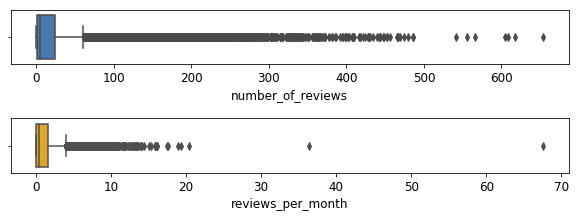

In [69]:
#Visualise the features with the most outliers

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,3]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, 1)

cols = ['number_of_reviews', 'reviews_per_month']

plt.subplots_adjust(hspace=1.0)
for i,col in enumerate(cols):
    sns.boxplot(df_flat_num[col], color=colors[i], ax=axs[i])
    axs[i].set_xlabel(col)
plt.show()

It is better to drop the columns, rather than the outlying values. Reasons:

* They consist in ~1/3 of the total amount of values in the DataFrame;
* They do not look like extremely vital features to know;
* reviews_per_month has also been heavily imputed, as it contained ~20% of missing data. It descriptivity is put into question anyway.

Therefore, we drop 'reviews_per_month' for sure and we let Cross-Validation decide the fate of 'number_of_reviews'.

In [70]:
df_flat_num = df_flat_num.drop('number_of_reviews', axis=1)
del out_list[out_list.index('reviews_per_month')]

### Scaling

In [71]:
df_ = df_flat_num.copy()
col_names = df_.columns

#Columns with outliers are
out_list = [col for col in out_list if col in col_names and col != 'price']
print(out_list)

#Columns without outliers
outfree_list = [col for col in col_names if col not in out_list]
print(outfree_list)

['latitude', 'minimum_nights']
['longitude', 'price', 'reviews_per_month', 'availability_365']


MinMax Scaler works well in general, but it is very sensitive to outliers. This is why we are coupling it to a RobustScaler.

In [72]:
#Scaling of columns without outliers
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
data_mm = minmax.fit_transform(df_flat_num[outfree_list])

df_mm = pd.DataFrame(data_mm, columns=outfree_list)
#df_mm.head()

In [73]:
#Scaling of columns with outliers
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
data_rs = robust.fit_transform(df_flat_num[out_list])

df_rs = pd.DataFrame(data_rs, columns=out_list)
#df_rs.head()

In [74]:
scal_df = pd.concat([df_mm, df_rs, df_flat_num['price']],axis=1)

scal_df.head()

longitude   price  reviews_per_month  availability_365  latitude  \
0   0.569257  0.0150           0.000000          1.000000  1.172794   
1   0.535649  0.0089           0.068343          0.526027 -0.514025   
2   0.565324  0.0080           0.001479          0.000000  1.029684   
3   0.506972  0.0200           0.008728          0.035616  0.337418   
4   0.542800  0.0060           0.005769          0.000000 -0.490332   

   minimum_nights  price  
0            0.25    150  
1           -0.25     89  
2            2.00     80  
3            0.25    200  
4           10.75     60

In [75]:
df_flat_num = scal_df

### Concatenate the two dataframes back and resample

In [76]:
df_scaled = pd.concat([df_flat_num,df_flat_cat],axis=1)
df_scaled.head()

longitude   price  reviews_per_month  availability_365  latitude  \
0   0.569257  0.0150           0.000000          1.000000  1.172794   
1   0.535649  0.0089           0.068343          0.526027 -0.514025   
2   0.565324  0.0080           0.001479          0.000000  1.029684   
3   0.506972  0.0200           0.008728          0.035616  0.337418   
4   0.542800  0.0060           0.005769          0.000000 -0.490332   

   minimum_nights  price  price_range  Allerton  Arden Heights  Arrochar  \
0            0.25    150            1         0              0         0   
1           -0.25     89            0         0              0         0   
2            2.00     80            0         0              0         0   
3            0.25    200            1         0              0         0   
4           10.75     60            0         0              0         0   

   Arverne  Astoria  Bath Beach  Battery Park City  Bay Ridge  Bay Terrace  \
0        0        0           0                  0          0            0   
1        0        0           0                  0          0            0   
2        0        0           0                  0          0            0   
3        0        0           0                  0          0            0   
4        0        0           0                  0          0            0   

   Bay Terrace, Staten Island  Baychester  Bayside  Bayswater  \
0                           0           0        0          0   
1                           0           0        0          0   
2                           0           0        0          0   
3                           0           0        0          0   
4                           0           0        0          0   

   Bedford-Stuyvesant  Belle Harbor  Bellerose  Belmont  Bensonhurst  \
0                   0             0          0        0            0   
1                   0             0          0        0            0   
2                   0             0          0        0            0   
3                   0             0          0        0            0   
4                   1             0          0        0            0   

   Bergen Beach  Boerum Hill  Borough Park  Breezy Point  Briarwood  \
0             0            0             0             0          0   
1             0            0             0             0          0   
2             0            0             0             0          0   
3             0            0             0             0          0   
4             0            0             0             0          0   

   Brighton Beach  Bronxdale  Brooklyn Heights  Brownsville  Bull's Head  \
0               0          0                 0            0            0   
1               0          0                 0            0            0   
2               0          0                 0            0            0   
3               0          0                 0            0            0   
4               0          0                 0            0            0   

   Bushwick  Cambria Heights  Canarsie  Carroll Gardens  Castle Hill  \
0         0                0         0                0            0   
1         0                0         0                0            0   
2         0                0         0                0            0   
3         0                0         0                0            0   
4         0                0         0                0            0   

   Castleton Corners  Charleston  Chelsea  Chinatown  City Island  \
0                  0           0        0          0            0   
1                  0           0        0          0            0   
2                  0           0        0          0            0   
3                  0           0        0          0            0   
4                  0           0        0          0            0   

   Civic Center  Claremont Village  Clason Point  Clifton  Clinton Hill  \
0             0    

__Important!__ We need to resample in some way in order to have an equal representation of all the target features. Any failure in doing so may result in bias.

In [77]:
rus = RandomUnderSampler(random_state=0)

X = df_scaled.drop(['price_range'], axis=1)
y = df_scaled.price_range.copy()
X_resampled, y_resampled = rus.fit_sample(X, y)

X = pd.DataFrame(X_resampled, columns=X.columns)
y = pd.Series(y_resampled)

features = X.copy()     
target = y.copy()       
df_ = X.copy()            
df_['price_range'] = target    

In [78]:
df_scaled = df_.copy()

## Preparing to classify price range: avoid the curse of dimensionality

In [79]:
df_class = df_scaled.drop('price', axis=1)
cols = df_class.columns.to_list()

#Move the target to last column spot for better readability
cols.insert(len(cols)-1, cols.pop(cols.index('price_range')))    

#### Cross Validation

In the following we will perform CrossValidation with a decision tree, together with a PCA, in order to gauge how many feature are truly necessary to describe the label and which they are.

In [80]:
#Check correlation first
df_class.corr().iloc[:(len(df_class.columns)-1),-1].abs().sort_values(ascending=False)

Entire home/apt               6.015080e-01
Private room                  5.911374e-01
Manhattan                     3.455591e-01
longitude                     3.269563e-01
Brooklyn                      2.071313e-01
Queens                        1.903934e-01
Midtown                       1.622418e-01
Bushwick                      1.465734e-01
Bedford-Stuyvesant            1.300696e-01
availability_365              1.286259e-01
Financial District            1.263786e-01
Shared room                   1.211234e-01
West Village                  1.153728e-01
Chelsea                       1.125550e-01
Hell's Kitchen                1.085300e-01
Bronx                         9.557671e-02
reviews_per_month             8.349180e-02
Murray Hill                   8.037437e-02
latitude                      7.868347e-02
Washington Heights            7.729570e-02
Harlem                        7.309593e-02
Flatbush                      7.214562e-02
Upper West Side               7.173723e-02
Tribeca    

In [81]:
#Split features from target
features = df_class.drop('price_range', axis=1)
target = df_class.price_range

In [82]:
cv = KFold(n_splits=5)            
accuracies = list()
max_attributes = 50       #len(list(features)) is ok if the features are not too many
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(df_class):
        f_train = df_class.loc[train_fold] # Extract train data with cv indices
        f_valid = df_class.loc[valid_fold] # Extract valid data with cv indices
        
        # We fit the model with the fold train data
        model = tree_model.fit(X = f_train.drop(['price_range'], axis=1), 
                               y = f_train['price_range'])      
        
        # We calculate accuracy with the fold validation data
        valid_acc = model.score(X = f_valid.drop(['price_range'], axis=1), 
                                y = f_valid['price_range'])     
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df_depth = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df_depth = df_depth[["Max Depth", "Average Accuracy"]]
print(df_depth.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.324479
         2          0.371700
         3          0.344734
         4          0.348090
         5          0.362078
         6          0.357146
         7          0.400162
         8          0.404407
         9          0.420578
        10          0.417223
        11          0.425915
        12          0.424944
        13          0.424661
        14          0.428583
        15          0.429836
        16          0.435213
        17          0.429513
        18          0.424540
        19          0.431332
        20          0.433556
        21          0.432868
        22          0.432100
        23          0.434526
        24          0.431453
        25          0.433475
        26          0.436547
        27          0.437437
        28          0.437760
        29          0.438650
        30          0.438286
        31          0.436224
        32          0.438043
        33          0.438165
        34    

In [83]:
#Fetch optimal max_depth from above
df_depth.iloc[df_depth['Average Accuracy'].idxmax(),:5]
m = df_depth.iloc[df_depth['Average Accuracy'].idxmax(),0]

In [84]:
#Vamos!
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth = m)
decision_tree.fit(features, target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=44,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [85]:
feat_imp = pd.Series(decision_tree.feature_importances_, index=features.columns).sort_values(ascending=False)
feat_imp

longitude                     0.227141
latitude                      0.202155
Entire home/apt               0.201033
reviews_per_month             0.122955
availability_365              0.110162
minimum_nights                0.066667
Midtown                       0.008635
Hotel room                    0.006077
Shared room                   0.002385
Upper East Side               0.001971
East Village                  0.001684
Upper West Side               0.001661
Bedford-Stuyvesant            0.001608
Chelsea                       0.001546
Hell's Kitchen                0.001458
Theater District              0.001392
Bushwick                      0.001372
Greenpoint                    0.001264
Clinton Hill                  0.001209
Murray Hill                   0.001184
Long Island City              0.001171
East Harlem                   0.001156
Astoria                       0.001079
SoHo                          0.001066
Harlem                        0.001065
Crown Heights            

In [86]:
num_feats = len([x for x in feat_imp if x>0.01])
imp_feats = list(feat_imp.index[:num_feats])
imp_feats

['longitude',
 'latitude',
 'Entire home/apt',
 'reviews_per_month',
 'availability_365',
 'minimum_nights']

Apparently, 6 features are enough to explain the entire statistics. Will PCA agree?

#### PCA

In [87]:
n = len(features.columns)

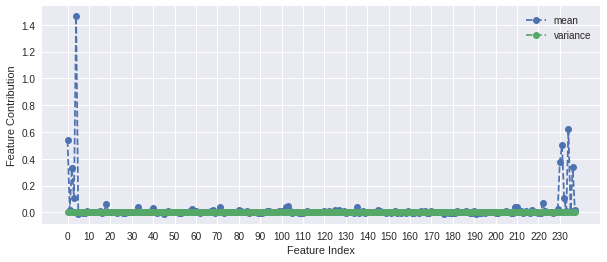

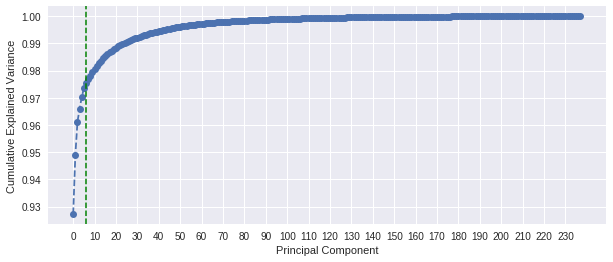

In [88]:
from sklearn.decomposition import PCA
import matplotlib.axes as ax

pca = PCA(n)
projected = pca.fit_transform(features)
pca_inversed_data = pca.inverse_transform(np.eye(n))

plt.style.use('seaborn')

def plot_pca():
    plt.figure(figsize=(10, 4))
    plt.plot(pca_inversed_data.mean(axis=0), '--o', label = 'mean')
    plt.plot(np.square(pca_inversed_data.std(axis=0)), '--o', label = 'variance')
    plt.ylabel('Feature Contribution')
    plt.xlabel('Feature Index')
    plt.legend(loc='best')
    plt.xticks(np.arange(0, n, 10))
    plt.show()

    plt.figure(figsize = (10, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '--o')
    plt.axvline(x = len(imp_feats), linewidth=1.5, color='green', ls='--')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.xticks(np.arange(0, n, 10))
    plt.show()

plot_pca()

Check! We can explain more than 97% of standard deviation with 6 attributes. The cumulative variance has an elbow around that value.

### Save the preprocessed dataframe

In [89]:
imp_feats.append('price_range')

In [90]:
df_class_prep = df_class[imp_feats].copy()

```python
#Create new database containing preprocessed data
create_PSQL_database("projektarbeit_preprocessed")

#Create string connection to database

new_str_db_typ = 'postgresql+psycopg2://'
new_str_db_user = 'postgres:'
new_str_db_password = '****' 
new_str_db_adr = '@localhost'
new_str_db_schema = '/projektarbeit_preprocessed'

new_str_connection = new_str_db_typ + new_str_db_user + new_str_db_password + new_str_db_adr + new_str_db_schema

#Create engine
new_engine = create_engine(new_str_connection)
```

```python
to_historised_table(df_class_prep, 'preprocessed_classification_data', new_str_connection)
```

# Implementation of ML algorithms

### Classification of the price range

In [91]:
X = df_class_prep.drop('price_range', axis=1)
y = df_class_prep['price_range']

In [92]:
#Splitting into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Since the dataset is not huge (at least with respect to real-world standards), we can start running a wide bunch of algorithms and see which performances are the best ones. The selected models will then be analysed in detail, _i.e._, they will be grid-searched and fine-tuned.

In [93]:
#Import some relevant classification algorithms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import ShuffleSplit #For Cross-Validation
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import time
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [94]:
models = [
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    SVC(),
    DecisionTreeClassifier(criterion='gini',max_depth=None),
    RandomForestClassifier(n_estimators=600),
    AdaBoostClassifier(),
    MLPClassifier()
]

Testing BernoulliNB
Learning time 0.018838882446289062s
Predicting time 0.003954410552978516s
=================== Results ===================
Precision   [0.71232123 0.50249688 0.57629339]
Recall      [0.81651955 0.46966161 0.5343048 ]
Accuracy: 0.6023852840105114

============== Confusion Matrix ===============



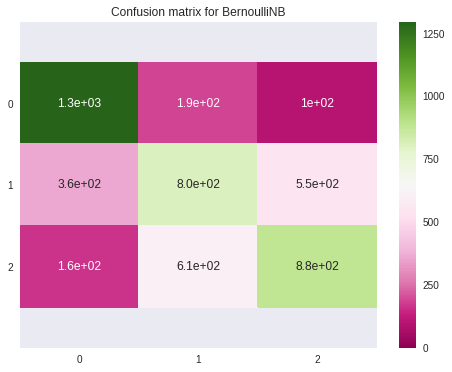



Testing GaussianNB
Learning time 0.017379283905029297s
Predicting time 0.003358125686645508s
=================== Results ===================
Precision   [0.69113791 0.4892916  0.53678586]
Recall      [0.83102144 0.17327888 0.79295689]
Accuracy: 0.5904588639579543

============== Confusion Matrix ===============



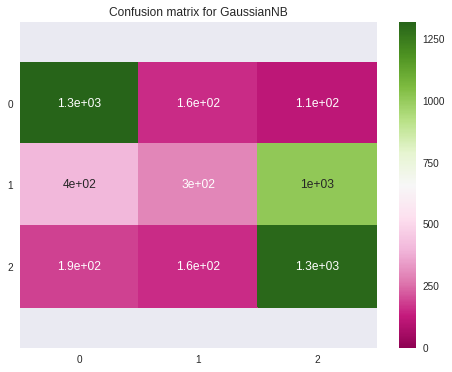



Testing KNeighborsClassifier
Learning time 0.07225608825683594s
Predicting time 0.24933266639709473s
=================== Results ===================
Precision   [0.71303395 0.51432209 0.62903226]
Recall      [0.82093317 0.4714119  0.59198543]
Accuracy: 0.623610268849808

============== Confusion Matrix ===============



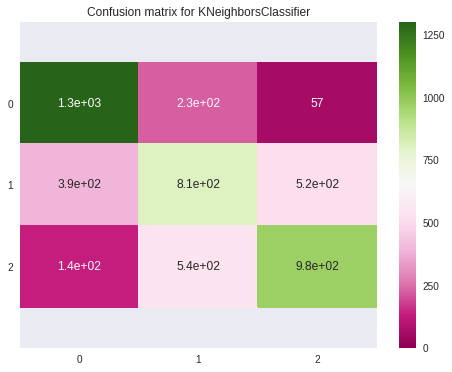



Testing LogisticRegression
Learning time 0.26578235626220703s
Predicting time 0.0017426013946533203s
=================== Results ===================
Precision   [0.70338528 0.52713816 0.58074866]
Recall      [0.82534678 0.373979   0.65938069]
Accuracy: 0.613705275924803

============== Confusion Matrix ===============



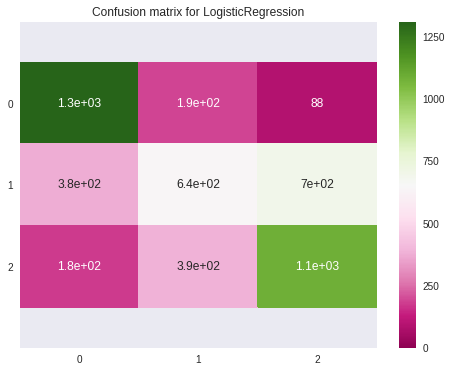



Testing SGDClassifier
Learning time 0.21524810791015625s
Predicting time 0.001405954360961914s
=================== Results ===================
Precision   [0.68619718 0.527897   0.48179653]
Recall      [0.76796974 0.07176196 0.85974499]
Accuracy: 0.5573074590661007

============== Confusion Matrix ===============



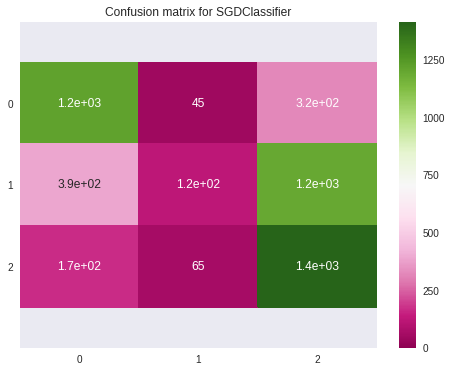



Testing LinearSVC
Learning time 6.152245759963989s
Predicting time 0.0016117095947265625s
=================== Results ===================
Precision   [0.69717935 0.53432282 0.57638191]
Recall      [0.8259773  0.33605601 0.69641773]
Accuracy: 0.6130988477865373

============== Confusion Matrix ===============



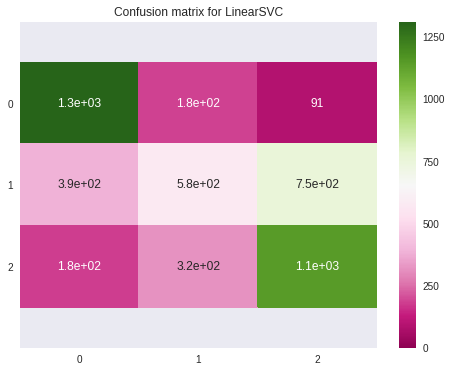



Testing SVC
Learning time 15.565685033798218s
Predicting time 1.583066701889038s
=================== Results ===================
Precision   [0.71224602 0.52464229 0.60599572]
Recall      [0.81778058 0.38506418 0.68731026]
Accuracy: 0.6244188397008288

============== Confusion Matrix ===============



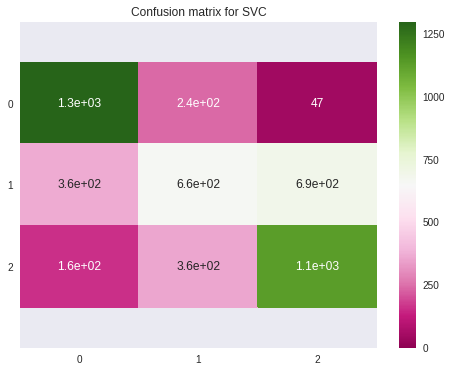



Testing DecisionTreeClassifier
Learning time 0.1665630340576172s
Predicting time 0.002568483352661133s
=================== Results ===================
Precision   [0.69680197 0.46400484 0.58333333]
Recall      [0.71437579 0.44749125 0.5907711 ]
Accuracy: 0.5807560137457045

============== Confusion Matrix ===============



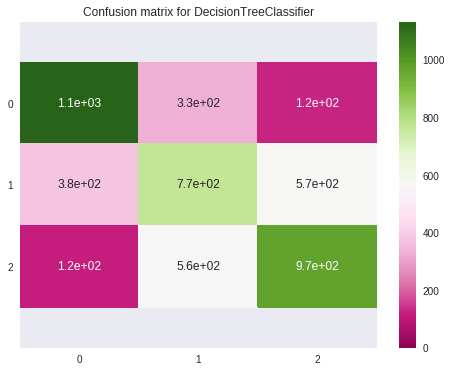



Testing RandomForestClassifier
Learning time 18.681743144989014s
Predicting time 0.8147118091583252s
=================== Results ===================
Precision   [0.76830732 0.5669587  0.66250743]
Recall      [0.80706179 0.5285881  0.67698846]
Accuracy: 0.6672730948049322

============== Confusion Matrix ===============



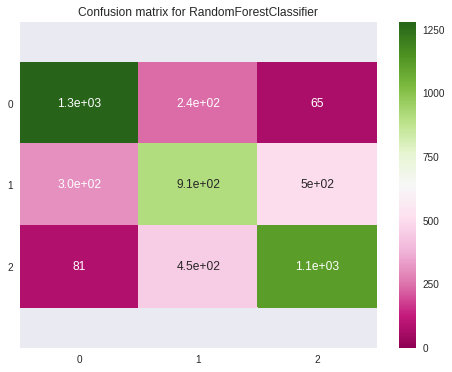



Testing AdaBoostClassifier
Learning time 0.7658078670501709s
Predicting time 0.03657126426696777s
=================== Results ===================
Precision   [0.74485126 0.53596889 0.63466184]
Recall      [0.82093317 0.48249708 0.63812993]
Accuracy: 0.6428138265615525

============== Confusion Matrix ===============



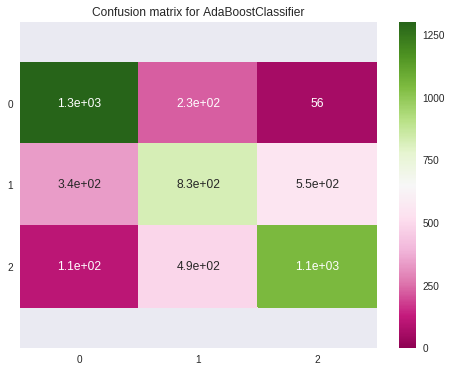



Testing MLPClassifier
Learning time 18.800312280654907s
Predicting time 0.015033960342407227s
=================== Results ===================
Precision   [0.75468384 0.53985507 0.619688  ]
Recall      [0.81273644 0.43465578 0.69945355]
Accuracy: 0.6440266828380837

============== Confusion Matrix ===============



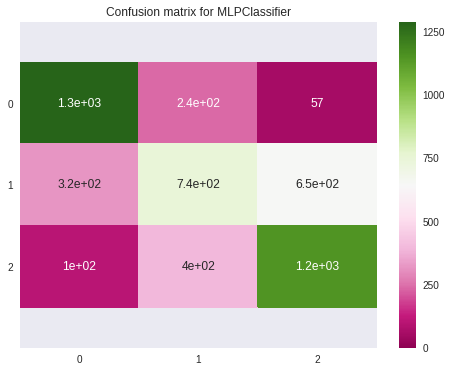

In [95]:
for model in models:
    print("===============================================")
    classifier_name = str(type(model).__name__)
    print("Testing " + classifier_name)
    now = time.time()
    list_of_labels = sorted(list(set(y_train)))
    fit = model.fit(X_train, y_train)
    print("Learning time {0}s".format(time.time() - now))
    now = time.time()
    predictions = fit.predict(X_test)
    print("Predicting time {0}s".format(time.time() - now))
    print("===============================================")
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    
    cms = confusion_matrix(y_test,predictions)
    print("=================== Results ===================")
    #print("            Negative     Neutral     Positive")
    print("Precision   " + str(precision))
    print("Recall      " + str(recall))
    print("Accuracy: " + str(accuracy))
    print()
    print("============== Confusion Matrix ===============")
    print()
    plt.figure(figsize = (8,6))
    sns.heatmap(cms, vmin=-1, cmap='PiYG', annot=True)
    plt.title('Confusion matrix for {}'.format(classifier_name))
    plt.yticks(rotation=0)
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    print("===============================================\n\n")

We can see that the best models are ensemble classifiers and neural networks. In particular, Random Forest performs well (accuracy > ~65%) and we can put it under the lens.

#### Fine-tuning the selected model

In [96]:
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier()

In [97]:
#Be patient, it takes quite some time to run. 
#Anyway, it's the best I can do on my machine...

param_grid = [{'n_estimators' : [600], 'criterion' : ['entropy', 'gini'], 
               'max_features': [3,5], 'bootstrap': [False, True]}]
grid_forest = GridSearchCV(model_rf, param_grid, cv=5)
grid_forest.fit(X_train, y_train)
grid_forest.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 3,
 'n_estimators': 600}

In [98]:
ft_model_rf = grid_forest.best_estimator_
ft_model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

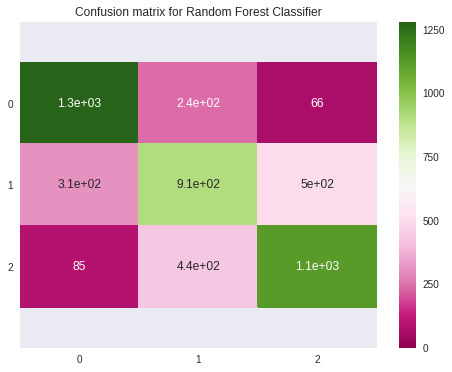

In [99]:
predictions = ft_model_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test,predictions)

#Plot
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, vmin=-1, cmap='PiYG', annot=True)
plt.title('Confusion matrix for Random Forest Classifier')
plt.yticks(rotation=0)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [100]:
rf_cr = classification_report(y_test,predictions)
print(rf_cr)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1586
           1       0.57      0.53      0.55      1714
           2       0.67      0.68      0.67      1647

    accuracy                           0.67      4947
   macro avg       0.67      0.67      0.67      4947
weighted avg       0.67      0.67      0.67      4947



**Some considerations:**
* The model works pretty cool when it has to examine cheap-to-expensive listings;
* The model performs poorly when it comes to classify normally priced accommodations. It can be a resampling problem, or maybe it alone was not enough;
* Maybe collinearities can spoil the categorization. For instance entire apartments are the most expensive kind of lodgings, and they mostly lie in Manhattan, the most expensive borough.

## Let's continue with some text mining. Which are the most used words, and what is their effect? 

In [101]:
#Let's refresh our memory
df_flat_text.head(3)

id                                              name neighbourhood  \
0  3647               THE VILLAGE OF HARLEM....NEW YORK !        Harlem   
1  3831                   Cozy Entire Floor of Brownstone  Clinton Hill   
2  5022  Entire Apt: Spacious Studio/Loft by central park   East Harlem   

  neighbourhood_group  
0           Manhattan  
1            Brooklyn  
2           Manhattan

In [102]:
#Wordcloud

#Needed for colors
from matplotlib import cm

host_names = df_host['host_name']
names = df_flat_text['name']
neighbourhood = df_flat_text['neighbourhood']
neighbourhood_group = df_flat_text['neighbourhood_group']

def make_wordcloud(words):
    '''A useful function to make a wordcloud'''
    
    text = ""
    for word in words:
        text = text + " " + word

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width=800, height=500,background_color='black', 
                          colormap=cm.plasma, random_state=21, max_font_size=110).generate(text)

    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud, interpolation="gaussian")
    plt.axis("off")
    plt.show()

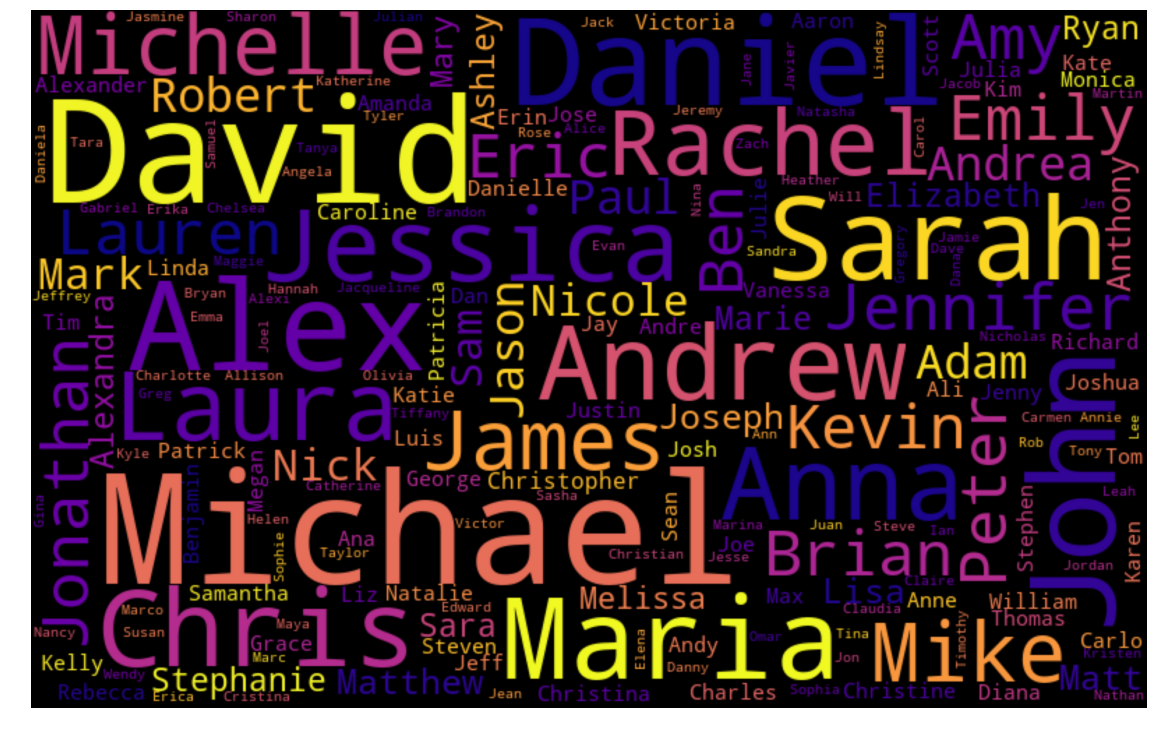

In [103]:
# Word cloud of host_names
make_wordcloud(host_names.astype('str'))

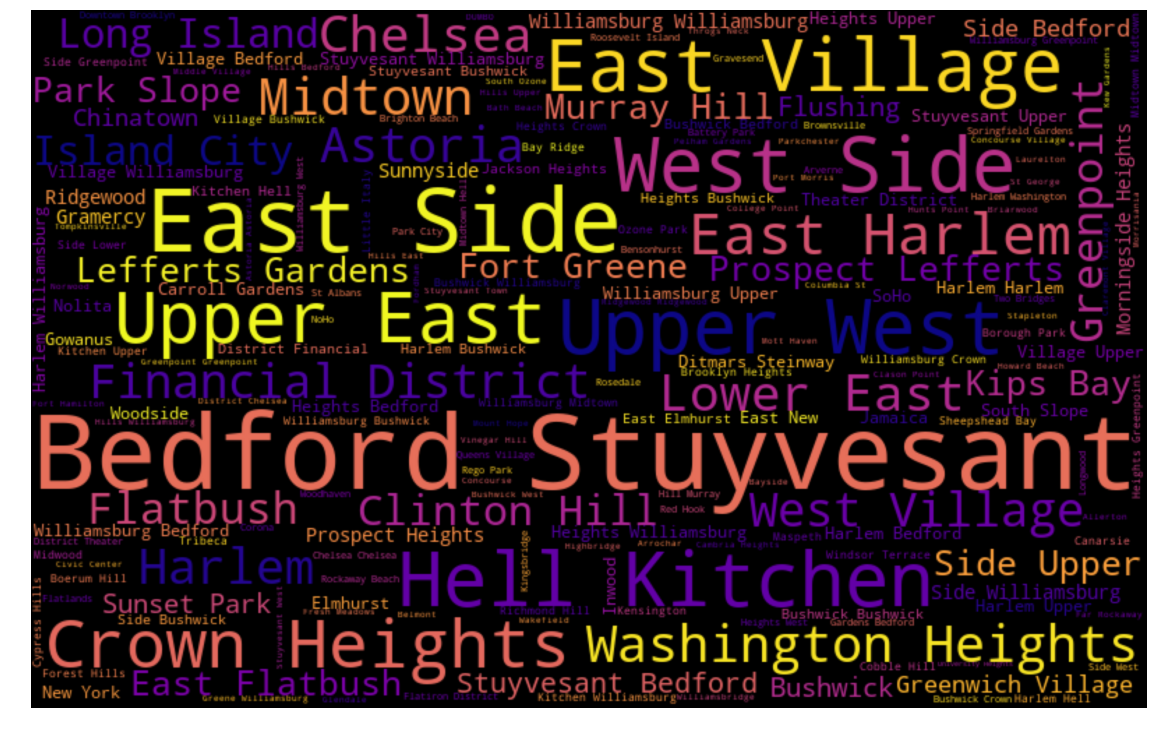

In [104]:
# Neighbourhoods
make_wordcloud(neighbourhood)

The most popular words correspond to Manhattan neighbourhoods, while the least cited are in Staten Island. This matches what we explored above.

#### Let's focus on the descriptions and tidy them up!

In [105]:
import string
import nltk

In [106]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [107]:
train = df_flat_text[['id','name']].copy()

In [108]:
train['name'].head()

0                 THE VILLAGE OF HARLEM....NEW YORK !
1                     Cozy Entire Floor of Brownstone
2    Entire Apt: Spacious Studio/Loft by central park
3           Large Cozy 1 BR Apartment In Midtown East
4                                     BlissArtsSpace!
Name: name, dtype: object

In [109]:
train['name'] = train['name'].astype(str)

#What names are the most frequent?
train['name'].value_counts()

Home away from home                                   19
Hillside Hotel                                        18
nan                                                   17
New york Multi-unit building                          16
Loft Suite @ The Box House Hotel                      11
                                                      ..
Sunny and Cozy HK bedroom for rent                     1
Garden Level Brooklyn Brownstone                       1
Beautiful West Harlem brownstone                       1
COZY, QUIET BEDROOM IN INWOOD, "UPSTATE MANHATTAN"     1
Private Room With Kitchen Across From MSG              1
Name: name, Length: 47420, dtype: int64

In [110]:
#Feature engineering
train['word_count'] = train['name'].apply(lambda x: len(str(x).split(" ")))

In [111]:
train.head()

id                                              name  word_count
0  3647               THE VILLAGE OF HARLEM....NEW YORK !           6
1  3831                   Cozy Entire Floor of Brownstone           5
2  5022  Entire Apt: Spacious Studio/Loft by central park           7
3  5099         Large Cozy 1 BR Apartment In Midtown East           8
4  5121                                   BlissArtsSpace!           1

In [112]:
def avg_word(sentence):
  words = sentence.split()
  return sum(len(word) for word in words)/len(words)

train['avg_word'] = train['name'].apply(lambda x: avg_word(x))
train[['name','avg_word']].head()

name  avg_word
0               THE VILLAGE OF HARLEM....NEW YORK !      5.00
1                   Cozy Entire Floor of Brownstone      5.40
2  Entire Apt: Spacious Studio/Loft by central park      6.00
3         Large Cozy 1 BR Apartment In Midtown East      4.25
4                                   BlissArtsSpace!     15.00

In [113]:
#Removing twitter handles (@user)
train['tidy_name'] = np.vectorize(remove_pattern)(train['name'], "@[\w]*")

#Removing special characters, numbers, punctuations
train['tidy_name'] = train['tidy_name'].str.replace("[^a-zA-Z#]", " ")

#Removing Short Words
train['tidy_name'] = train['tidy_name'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [114]:
train.head()

id                                              name  word_count  \
0  3647               THE VILLAGE OF HARLEM....NEW YORK !           6   
1  3831                   Cozy Entire Floor of Brownstone           5   
2  5022  Entire Apt: Spacious Studio/Loft by central park           7   
3  5099         Large Cozy 1 BR Apartment In Midtown East           8   
4  5121                                   BlissArtsSpace!           1   

   avg_word                                 tidy_name  
0      5.00                       VILLAGE HARLEM YORK  
1      5.40              Cozy Entire Floor Brownstone  
2      6.00  Entire Spacious Studio Loft central park  
3      4.25         Large Cozy Apartment Midtown East  
4     15.00                            BlissArtsSpace

In [115]:
#Tokenization
tokenized_name = train['tidy_name'].apply(lambda x: x.split())
tokenized_name.head()


0                            [VILLAGE, HARLEM, YORK]
1                  [Cozy, Entire, Floor, Brownstone]
2    [Entire, Spacious, Studio, Loft, central, park]
3            [Large, Cozy, Apartment, Midtown, East]
4                                   [BlissArtsSpace]
Name: tidy_name, dtype: object

In [116]:
#Stemming removes endings
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_name = tokenized_name.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_name.head()

0                           [villag, harlem, york]
1                  [cozi, entir, floor, brownston]
2    [entir, spaciou, studio, loft, central, park]
3               [larg, cozi, apart, midtown, east]
4                                  [blissartsspac]
Name: tidy_name, dtype: object

In [117]:
#Join tokenized strings
for i in range(len(tokenized_name)):
    try:
        tokenized_name[i] = ' '.join(tokenized_name[i])
    except:
        tokenized_name[i] = 0

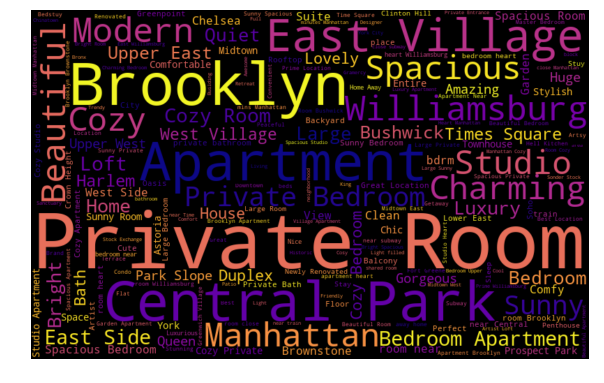

In [118]:
#Visualisation of all the words
all_words = ' '.join([text for text in train['tidy_name']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, background_color='black', colormap=cm.plasma, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

This wordcloud shows that:
* Somebody who rents an accommodation in a trendy/turistic area is more likely to mention it to allure customers. This is why words like "Brooklyn" and "Central Park" are more used than others;
* Concerning the characteristics of a listing, the most used words seems to be "private", probably in connection to the bathroom. It makes a lot of sense;
* There is an overuse of adjectives like "cozy", "beatiful", "modern", etc.  

To print all the words, just run:

```python
all_word = re.split(r"\s+", all_words)
print(all_word)
```

# Time Series Analysis: is there a seasonality in the data? 

In [119]:
#Creation of appropriate time series
df_ts['count']=1

#Drop reviews preceding 2016
df_ts.drop(df_ts.loc[df_ts['last_review'] < '2016-01-01'].index , inplace=True)
df_ts2=df_ts.iloc[:,1:].groupby(['last_review']).sum()

df_tmp=df_ts.reset_index()
df_tmp['last_review']=pd.to_datetime(df_flat['last_review'])
df_tmp['last_review'].dtype
df_ts2

count
last_review       
2016-01-01      36
2016-01-02      71
2016-01-03      65
2016-01-04       1
2016-01-05      59
...            ...
2019-09-08    1172
2019-09-09     905
2019-09-10     604
2019-09-11     434
2019-09-12     330

[1329 rows x 1 columns]

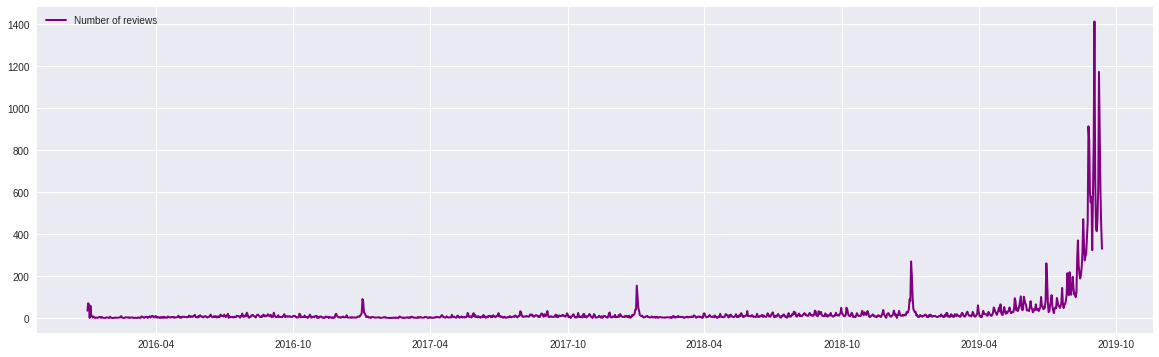

In [120]:
plt.figure(figsize=(20,6))
plt.plot(df_ts2, linewidth=2, color='purple')
plt.legend(['Number of reviews'], loc='upperleft')
plt.show()

In [121]:
#Division into training and test data
i_split = int(0.8*len(df_ts2))

df_train, df_test = df_ts2.iloc[:i_split,:], df_ts2.iloc[i_split:,:]

print('Train and Test are made of {} entries in total.'.format(len(df_train)+len(df_test)))
print('All forecasts must be {} periods long.'.format(len(df_test)))
df_train.head()

Train and Test are made of 1329 entries in total.
All forecasts must be 266 periods long.


count
last_review       
2016-01-01      36
2016-01-02      71
2016-01-03      65
2016-01-04       1
2016-01-05      59

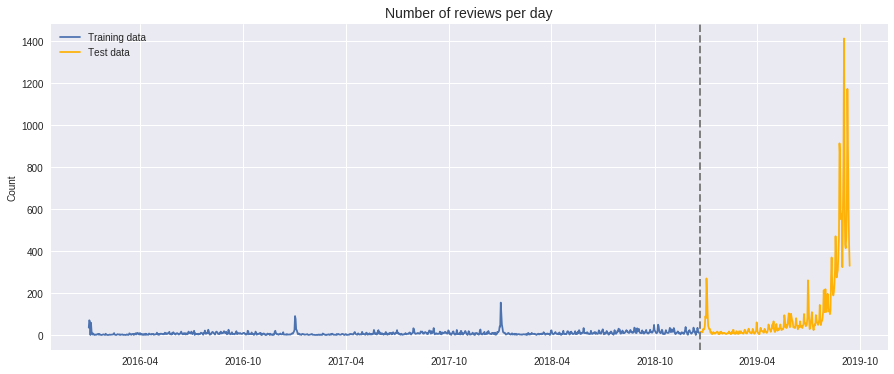

In [122]:
#Visualise the splitting on the number of reviews
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Training data')
plt.plot(df_test.index, df_test.values, label='Test data', color=colors[1])

plt.axvline(x = df_ts2.index[i_split], linewidth=2, color='grey', ls='--')
plt.legend(loc=2, fontsize=10)
plt.title('Number of reviews per day'.format(df_train.columns[0]), fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.show()

In [123]:
#Some modules to evaluate seasonal effects
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#### We see effects through Christmas and New Year's Eve trips based on the reviews over time!

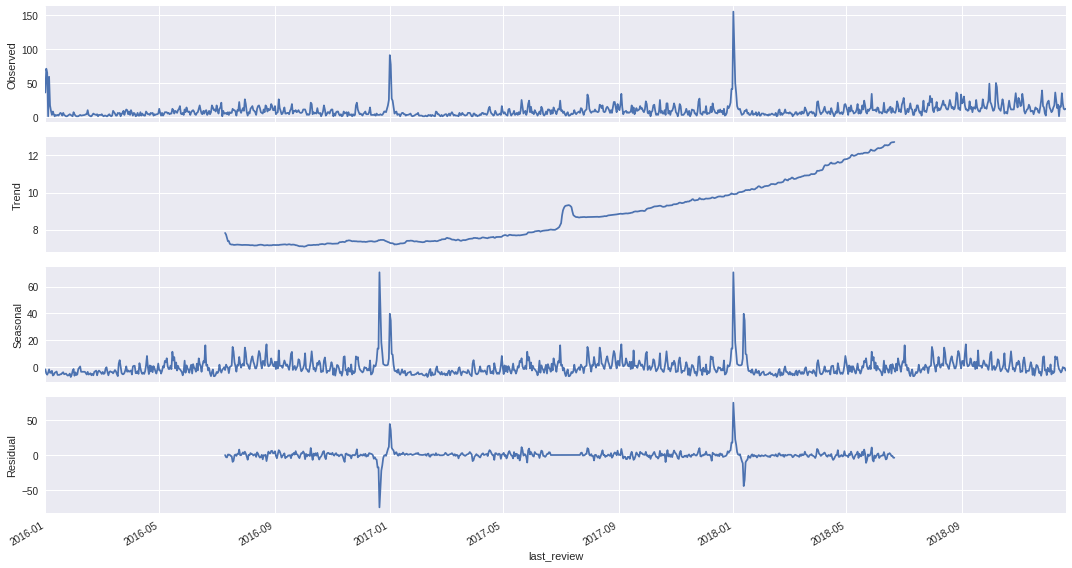

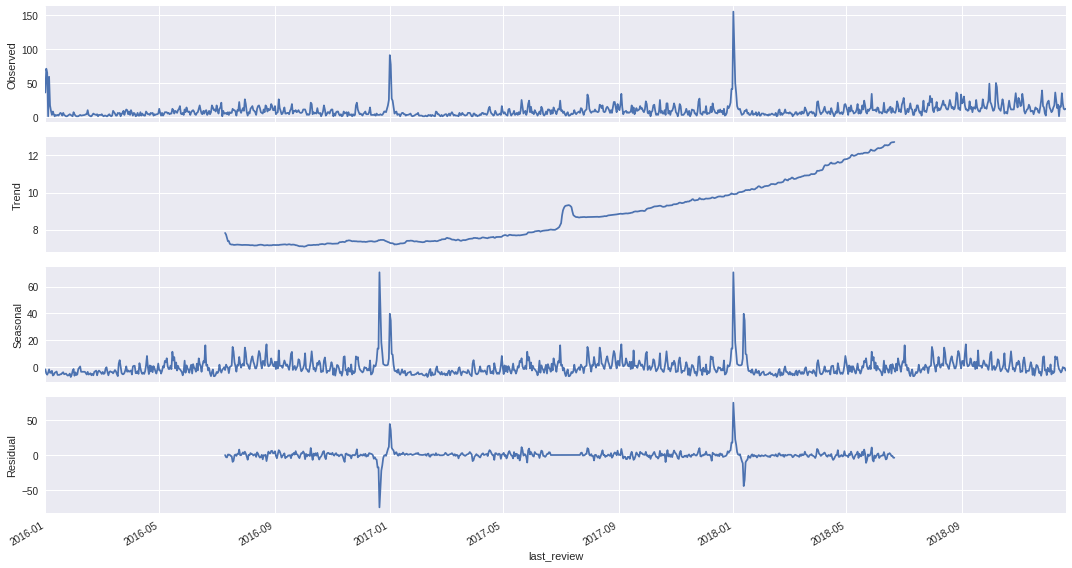

In [124]:
#Yearly frequence

plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train['count'],freq=365).plot()
#plt.show()

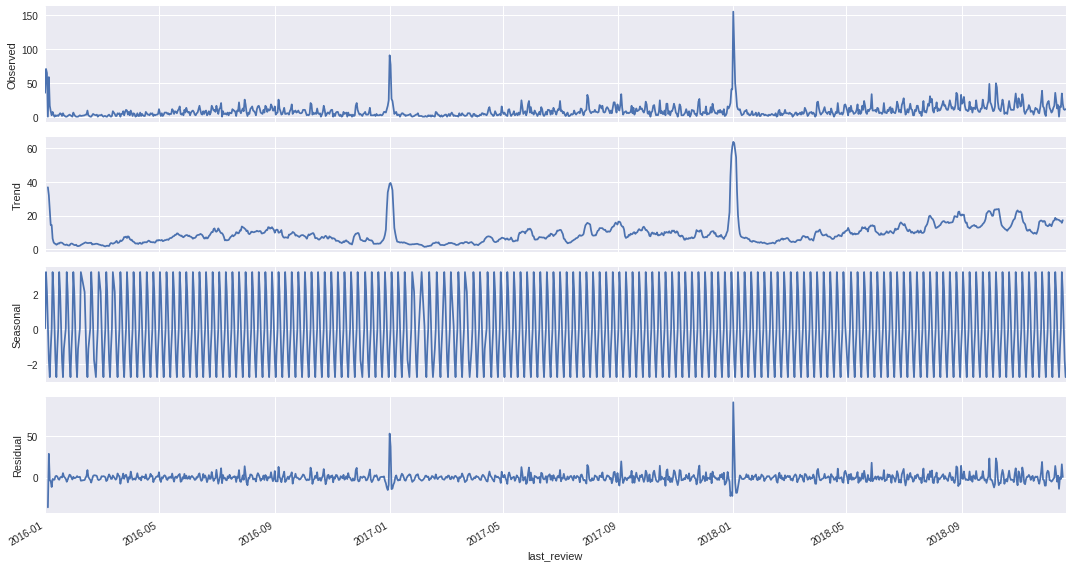

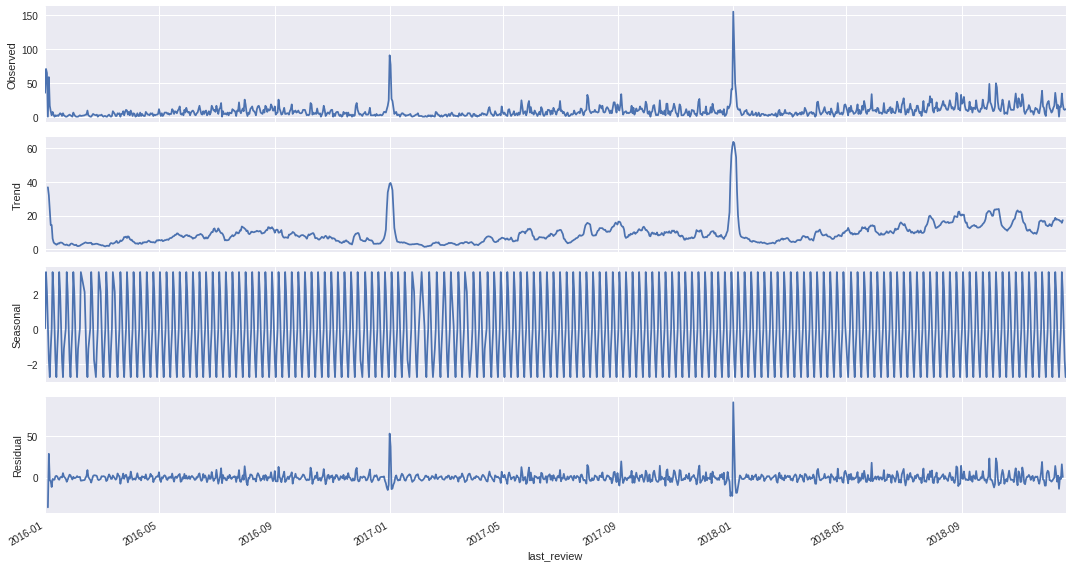

In [125]:
#Weekly decomposition

plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train['count'],freq=7).plot()

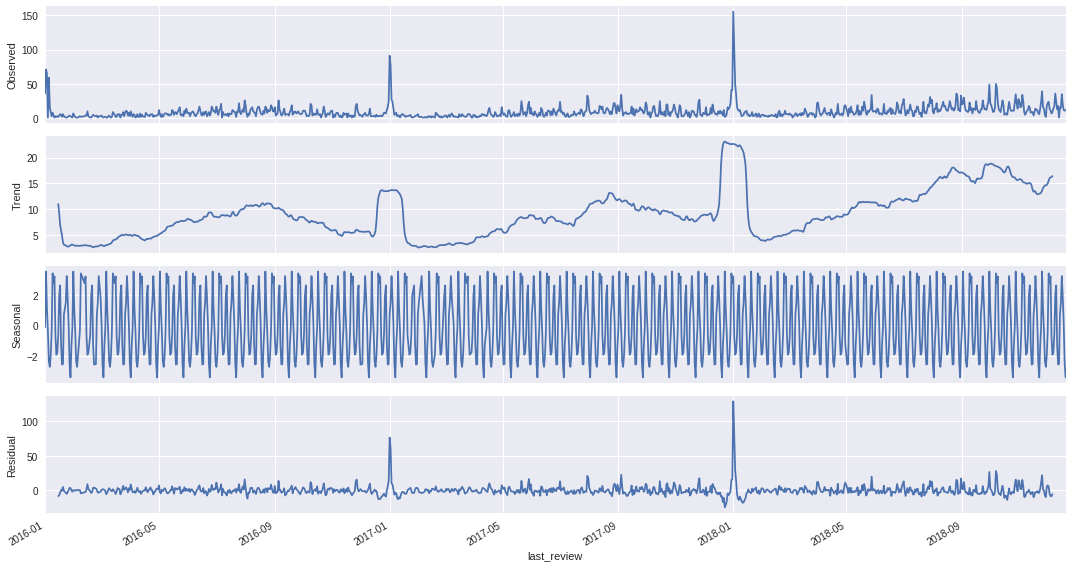

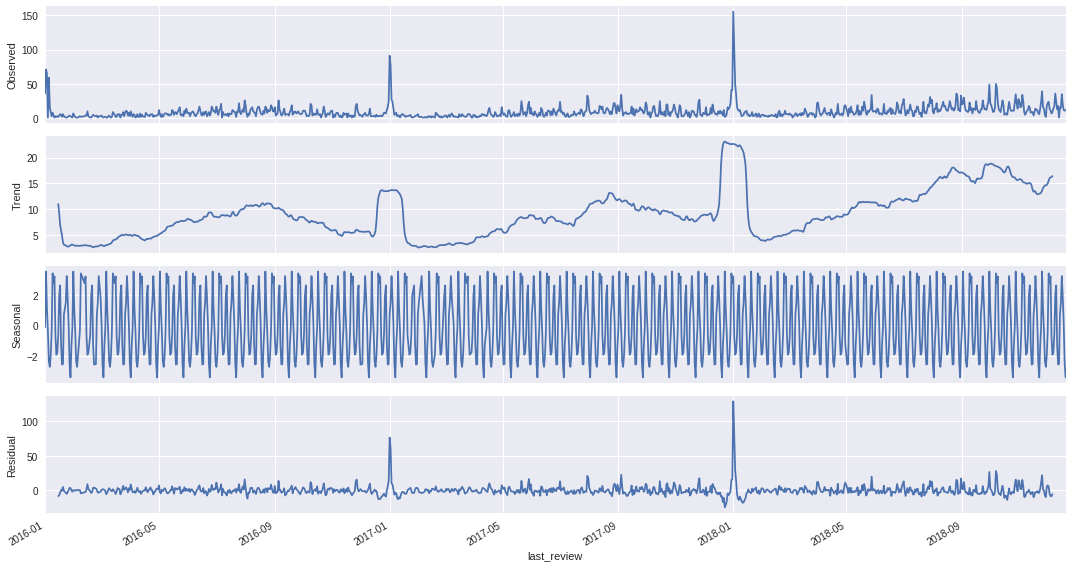

In [126]:
#Monthly effects

plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train['count'],freq=28).plot()

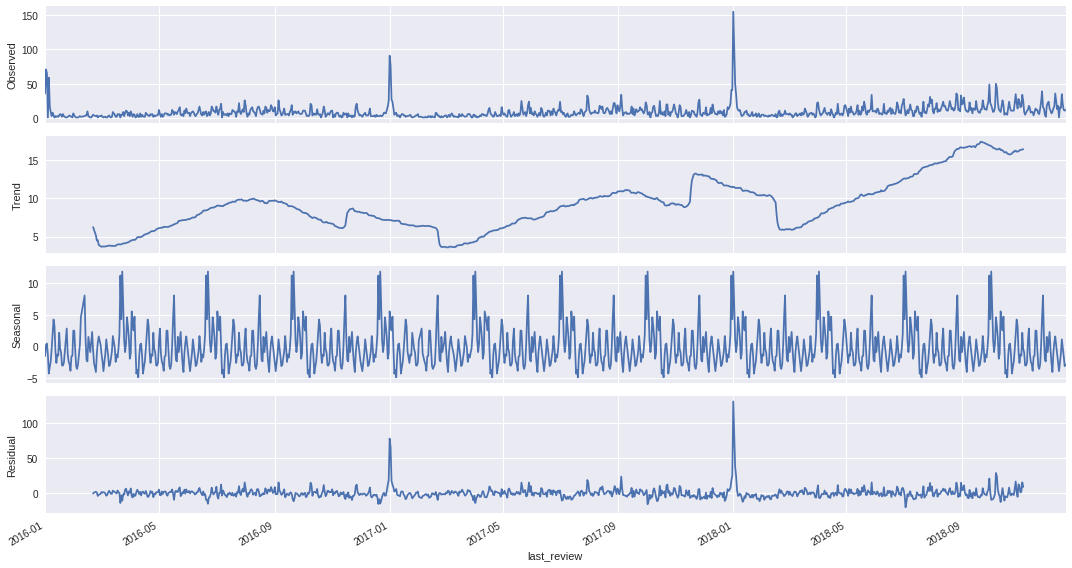

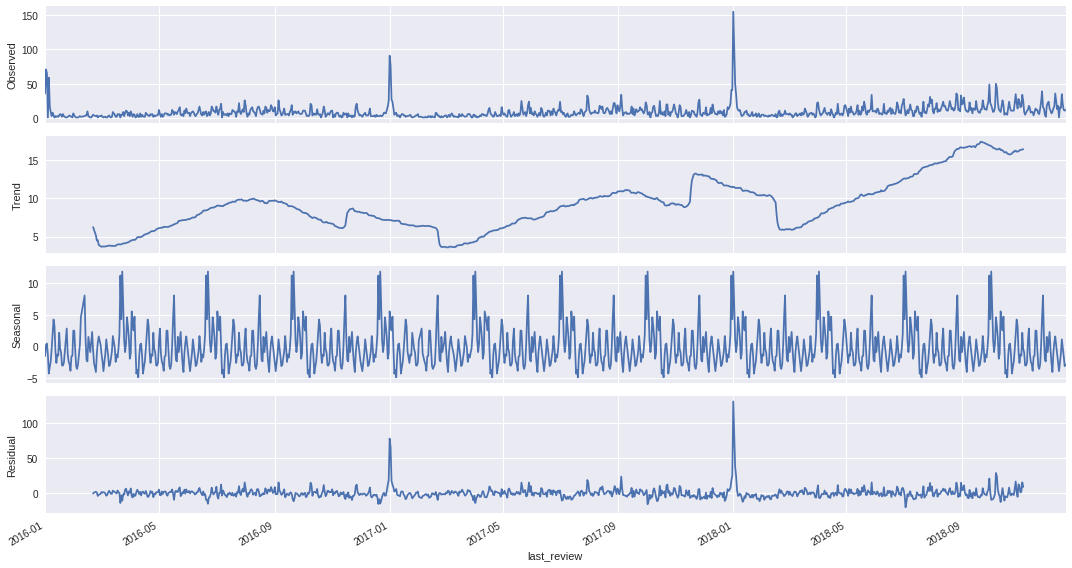

In [127]:
#Quarterly effects

plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train['count'],freq=91).plot()

Let's estimate the errors on the seasonality effects now.

In [128]:
fit1 = ExponentialSmoothing(df_train, seasonal_periods=365, trend='add', seasonal='add').fit(use_boxcox=True)
fcast1 = fit1.forecast(len(df_test)).rename("Holt-Winters Additive")

In [129]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(df_test, fcast1.values))
me = (df_test.iloc[:,0] - fcast1.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast1.values)
stdres = residuen.std()
print('Forecast Holt Winters Additive   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast Holt Winters Additive   -   RMSE: 204.7483, ME: 82.9453, StdRes: 187.5477


In [130]:
df_ = df_ts.copy()
s_Dates = pd.to_datetime(df_.iloc[:,1], format='%Y-%m-%d', errors='ignore')
#s_Dates.head()

##### Lastly, in which days of the week the most of the reviews is written?

In [131]:
#Label the weekdays by number
df_NuDay = pd.DataFrame(s_Dates.dt.dayofweek.value_counts(dropna=False))
df_NuDay = df_NuDay.reset_index()
df_NuDay.columns=['#Day', 'Count']
        
#Label the weekdays by name
df_NaDay = pd.DataFrame(s_Dates.dt.day_name().value_counts(dropna=False))
df_NaDay = df_NaDay.reset_index()
df_NaDay.columns=['Day', 'Count']

df_weekday = df_NaDay.merge(df_NuDay, on='Count').sort_values(by=['#Day']).reset_index(drop=True)
df_weekday

Day  Count  #Day
0     Monday   7237     0
1    Tuesday   4916     1
2  Wednesday   4163     2
3   Thursday   3806     3
4     Friday   3701     4
5   Saturday   5023     5
6     Sunday   8265     6

In [132]:
df_NuDay

#Day  Count
0     6   8265
1     0   7237
2     5   5023
3     1   4916
4     2   4163
5     3   3806
6     4   3701

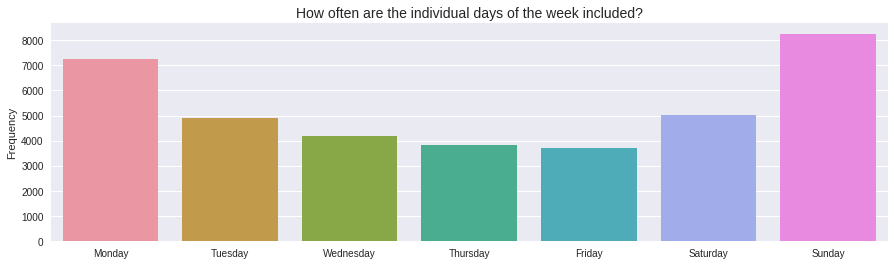

In [133]:
#Graphically

plt.rcParams['figure.figsize'] = [15, 4]
fig=sns.barplot(x='Day', y='Count', data=df_weekday)

plt.title("How often are the individual days of the week included?", size=14)
plt.xlabel("")
plt.ylabel("Frequency")

plt.show()

The reviews also show some seasonality during the week, most reviews are written on Sundays and Mondays

# Conclusions & outlook

**What we learned:**
* The price tag can be stratified and a classification algorithm can be trained. However, listings whose price lies between 100\\$ and 200\\$ are not accurately predicted;
* Text mining is very useful. It confirms many insights of EDA, while giving an idea of communication trends towards the possible guests. If one has time, it can be nice to repeat this approach on the (bigger) dataset of reviews from the users;
* We can spot some seasonal effects around Christmas holidays and in the weekly counting of reviews.

**Possible future actions:**
* Analyse the normal priced listings alone and try to find what are the features which describe them better;
* Perform 5 separate, borough-by-borough, classifications. A huge boost in performance can be the smoking gun for some dishomogeneity on the distribution of the sample;
* Divide the price range in more bins and look at the change. Just 2 bins may be too little, considering the skewness of 'price';
* Use the residuals of a regression analysis on the 'price' target to try detecting collinearity; 
* Try to find some other features from the web-scraping dataset listing.csv.gz, which can be more correlated with 'price_range'. Perform some feature engineering if necessary.